# Preliminaries

In [1]:
#@title Install libraries
%%capture
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install vincenty

In [2]:
#@title Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
import os
import sys

os.chdir(r'/gdrive/My Drive/Colab Notebooks/GITHUB/X_PFB')
if "." not in sys.path:
  sys.path.append(".")

In [4]:
#@title GPU/CPU, RAM info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('No GPU')
else:
  print(gpu_info)

# Check GPU is available
# https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm
# import tensorflow as tf
# tf.test.gpu_device_name()

# List of CPU
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


No GPU


In [5]:
#@title import libraries
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import time
import copy

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

import catboost
import tensorflow as tf

# My helpers
import helpers.run_model as run_model
import helpers.tune_model as tune_model
import helpers.data_prep as data_prep

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.03f}'.format

sns.set(color_codes=True)

# Reimport after change
import importlib
# importlib.reload(run_model)  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

# Dataset

In [10]:
#@title Load dataset
DATA_DIR = 'data/'
SEED_FOR_SPLIT = 0  # random_state for split
#x_train = pickle.load(open(DATA_DIR + 'x_train.beforeOneHot.pickle', 'rb'))
x_train = pd.read_csv(DATA_DIR+'prepared/x_train.csv.zip', compression='zip')
y_train = pd.read_csv(DATA_DIR + 'y_train.csv')
x_test = pd.read_csv(DATA_DIR+'prepared/x_test.csv.zip', compression='zip')

print('shapes: ', x_train.shape, y_train.shape)

# -- Categorical features
cat_features = ['alert reason category', 'alert reason', 'intervention on public roads', 'floor', 
                'location of the event', 
                'emergency vehicle', 
                #'emergency vehicle type', 
                'vehicule_type', 'vehicule_ownrer',
                'rescue center', 
                'status preceding selection', 'departed from its rescue center', 
                'selection_weekday', 'selection_month', 'selection_day', 'selection_hour', 'selection_is_holiday',
                'waypoint1_name', 'waypoint2_name',
                'intervention_place', # 20200420
                'waypoint3_name', 'waypoint4_name',
                ]
cat_features_idx = [i for i, name in enumerate(x_train.columns) if name in cat_features]

# -- Target variables
Y_NAMES = list(y_train.columns[1:].values)
print(Y_NAMES)
print(cat_features)
print(cat_features_idx)
# y_name by default
y_name = Y_NAMES[1]
print('y_name by default', y_name)

# -- split
x_train_sp, x_test_sp, y_train_sp, y_test_sp = train_test_split(
    x_train,
    y_train, 
    test_size=0.33, 
    random_state=SEED_FOR_SPLIT
    )
print('Split dataset shapes', x_train.shape, x_test_sp.shape)

shapes:  (219337, 64) (219337, 4)
['delta selection-departure', 'delta departure-presentation', 'delta selection-presentation']
['alert reason category', 'alert reason', 'intervention on public roads', 'floor', 'location of the event', 'emergency vehicle', 'vehicule_type', 'vehicule_ownrer', 'rescue center', 'status preceding selection', 'departed from its rescue center', 'selection_weekday', 'selection_month', 'selection_day', 'selection_hour', 'selection_is_holiday', 'waypoint1_name', 'waypoint2_name', 'intervention_place', 'waypoint3_name', 'waypoint4_name']
[0, 1, 2, 3, 4, 7, 8, 11, 13, 23, 24, 25, 26, 27, 32, 35, 38, 41, 60, 61, 63]
y_name by default delta departure-presentation
Split dataset shapes (219337, 64) (72382, 64)


In [11]:
#@title restrict datatset for y0
# Restricts features set
feats_4y0 = ['paris2departure_km',
            'paris2departure_bearing',
            'longitude before departure',
            'latitude before departure',
            'alert reason category',
            'alert reason',
            'intervention on public roads',
            'location of the event',
            'emergency vehicle',
            #'emergency vehicle type',
            'vehicule_type', 'vehicule_ownrer',
            'rescue center',
            'status preceding selection',
            'delta status preceding selection-selection',
            'departed from its rescue center',
            'date key sélection',
            'time key sélection',
            'selection_weekday',
            'selection_month',
            'selection_day',
            'selection_hour',
            'selection_is_holiday',
            'time elapsed between selection and last observed GPS position', 
            'updated OSRM estimated duration',
            'delta position gps previous departure-departure',
            ]
x_train_4y0 = x_train[feats_4y0]
x_test_4y0 = x_test[feats_4y0]
cat_features_4y0 = [c for c in cat_features if c in feats_4y0]
cat_features_4y0_idx = [i for i, c in enumerate(x_train_4y0.columns) if c in cat_features_4y0]
x_train_sp_4y0, x_test_sp_4y0, y_train_sp, y_test_sp = train_test_split(
    x_train_4y0,
    y_train, 
    test_size=0.33, 
    random_state=SEED_FOR_SPLIT
    )
print('cat_features_4y0:', cat_features_4y0)
print('x_train shape before/after', x_train.shape, x_train_sp_4y0.shape)

cat_features_4y0: ['alert reason category', 'alert reason', 'intervention on public roads', 'location of the event', 'emergency vehicle', 'vehicule_type', 'vehicule_ownrer', 'rescue center', 'status preceding selection', 'departed from its rescue center', 'selection_weekday', 'selection_month', 'selection_day', 'selection_hour', 'selection_is_holiday']
x_train shape before/after (219337, 64) (146955, 25)


In [12]:
x_train_ori = pd.concat([pd.read_csv(DATA_DIR+'x_train.csv'),
                         pd.read_csv(DATA_DIR+'x_train_additional_file.csv'),
                         ], axis=1)


In [ ]:
# Pool data for catboost
# train_pools, test_pools = [None]*2, [None]*2
# for i, y_name in enumerate(Y_NAMES):
#     train_pools[i] = catboost.Pool(
#         x_train_sp, 
#         label=y_train_sp[y_name],
#         cat_features=cat_features)
#     test_pools[i] = catboost.Pool(
#         x_test_sp, 
#         label=y_test_sp[y_name],
#         cat_features=cat_features)

# Reload models

In [33]:
mY1 = catboost.CatBoostRegressor()
mY1 = mY1.load_model("models/catboost.Y1.splitdata.model")

mY0 = catboost.CatBoostRegressor()
mY0 = mY0.load_model("models/catboost.Y0.alldata.model")

mY2 = catboost.CatBoostRegressor()
mY2 = mY2.load_model("models/catboost.Y2.alldata.model")

In [34]:
#@title R2 / Y1 (Delta departure-presentation)
r2_score(y_true=y_test_sp['delta departure-presentation'],
         y_pred=mY1.predict(x_test_sp))

0.425238527955596

In [36]:
#@title feature importance of the 3 models (Y0, Y1, Y2)
models = [mY0, mY1, mY2]
pd.concat([m.get_feature_importance(prettified=True) for m in models], axis=1).head(15)

Feature Id  Importances                                         Feature Id  Importances                                         Feature Id  Importances
0                                      selection_hour       17.901                             GPS_Tracks_duration_hr       30.155                                            y1_pred       71.234
1   time elapsed between selection and last observ...       13.848                            OSRM estimated distance       13.725  time elapsed between selection and last observ...       10.667
2                                   emergency vehicle        7.767                            OSRM estimated duration       10.585                            OSRM estimated distance        2.158
3                                       vehicule_type        7.293  time elapsed between selection and last observ...        7.378                              paris2intervention_km        1.574
4                              GPS_Tracks_duration_hr        7.199                                 GPS_Tracks_records        6.969                             GPS_Tracks_duration_hr        1.571
5                                             y1_pred        6.118                    updated OSRM estimated duration        2.497                                 GPS_Tracks_records        1.333
6          delta status preceding selection-selection        5.952                                       alert reason        1.948                                     selection_hour        1.278
7                                             y2_pred        5.737                                      vehicule_type        1.826                    updated OSRM estimated duration        1.231
8                                  time key sélection        4.657                                     speed_mean_kmh        1.490                                 GPS_Tracks_std_kmh        1.195
9                                       rescue center        2.719                                 time key sélection        1.125                                 time key sélection        0.798
10                                 GPS_Tracks_records        2.171                                  emergency vehicle        1.011                            OSRM estimated duration        0.606
11                                       alert reason        1.834                                      rescue center        0.994                                      vehicule_type        0.512
12                              alert reason category        1.709                                 intervention_place        0.915                                    vehicule_ownrer        0.407
13                    updated OSRM estimated duration        1.660                                     selection_hour        0.905                                    selection_month        0.402
14                                  selection_weekday        0.818                                GPS_Tracks_mean_kmh        0.883                              alert reason category        0.376

# Analyze how R2 was composed

## Y1

There are only 2 points that account for a very portion of R2 decrease (0.10 in value).

In [35]:
# Residuals dataframe
res_df = pd.DataFrame({'y_true': y_test_sp['delta departure-presentation']})
res_df['y_pred'] = mY1.predict(x_test_sp)
res_df['resid'] = res_df.y_pred - res_df.y_true
resid_stddev = res_df['resid'].std()
res_df['resid_standardized'] = res_df['resid']/resid_stddev
res_df = pd.concat([res_df, x_test_sp], axis=1)
res_df.head(5)

y_true  y_pred    resid  resid_standardized  alert reason category  alert reason  intervention on public roads  floor  location of the event  longitude intervention  latitude intervention  emergency vehicle  rescue center  date key sélection  time key sélection status preceding selection  delta status preceding selection-selection  departed from its rescue center  longitude before departure  latitude before departure  delta position gps previous departure-departure  OSRM estimated distance  OSRM estimated duration  OSRM estimated distance from last observed GPS position  OSRM estimated duration from last observed GPS position  time elapsed between selection and last observed GPS position  updated OSRM estimated duration  selection_weekday  selection_month  selection_day  selection_hour  selection_is_holiday  OSRM_estimated_speed  departure2intervention_bearing  mid_point_lat  mid_point_lon       waypoint1_name  waypoint1_lon  waypoint1_lat        waypoint2_name  \
211149     425 443.377   18.377               0.103                      3          2163                             0      0                    140                   2.429                 48.742               5734           2451            20181214              200446                     Rentré                                        1976                                1                       2.410                     48.753                                            0.000                 2671.600                  404.600                                             16.100                                                    2.300                                                  511.963                                      514.263                  4               12             14              20                 False                 6.603                         133.717         48.748          2.419     Rue Jules Vallès          2.411         48.753        Rue de la Paix   
3906       246 256.535   10.535               0.059                      3          2162                             0      1                    136                   2.438                 48.909               5625           2460            20180628              165124                     Rentré                                        5935                                1                       2.440                     48.920                                            0.000                 1801.500                  160.000                                            145.500                                                   15.000                                                  335.477                                      350.477                  3                6             28              16                 False                11.259                         188.544         48.915          2.439   Rue Louis Delplace          2.441         48.920    Avenue Jean Jaurès   
43222      705 208.997 -496.003              -2.780                      3          2162                             0      0                    136                   2.403                 48.869               5702           2475            20180525              233020                     Rentré                                        1430                                1                       2.404                     48.872                                            0.000                  524.000                   94.700                                              0.000                                                    0.000                                                    0.000                                        0.000                  4                5             25              23                 False                 5.533                         188.180         48.870          2.403             Rue Haxo          2.404         48.872    Rue Ernest Lefèvre   
38143      489 507.988   18.988               0.106         

In [38]:
res_df[['y_true',	'y_pred',	'resid',	'resid_standardized']].describe()
# The mean residual, 3s, is not bad at all if we considered the mean response variable is 356s (~11 min)
# The bad number in R2 is explained by extreme values in residuals.
# Only above the 80% percentile, the residuals exceeds 8 min.

y_true    y_pred      resid  resid_standardized
count 72382.000 72382.000  72382.000           72382.000
mean    356.131   352.933     -3.198              -0.018
std     235.369   146.947    178.412               1.000
min       1.000    17.489 -21706.537            -121.665
25%     231.000   262.202    -34.945              -0.196
50%     319.000   328.833     14.088               0.079
75%     433.000   414.708     61.866               0.347
max   22722.000  7571.268   1023.640               5.738

In [40]:
# 80% of residuals are under 8.7 seconds
np.percentile(res_df.resid.values, 0.8)/60

-8.714569887432084

In [42]:
import helpers.analyze_model
import importlib
importlib.reload(helpers.analyze_model)

<module 'helpers.analyze_model' from '/gdrive/My Drive/Colab Notebooks/GITHUB/X_PFB/helpers/analyze_model.py'>

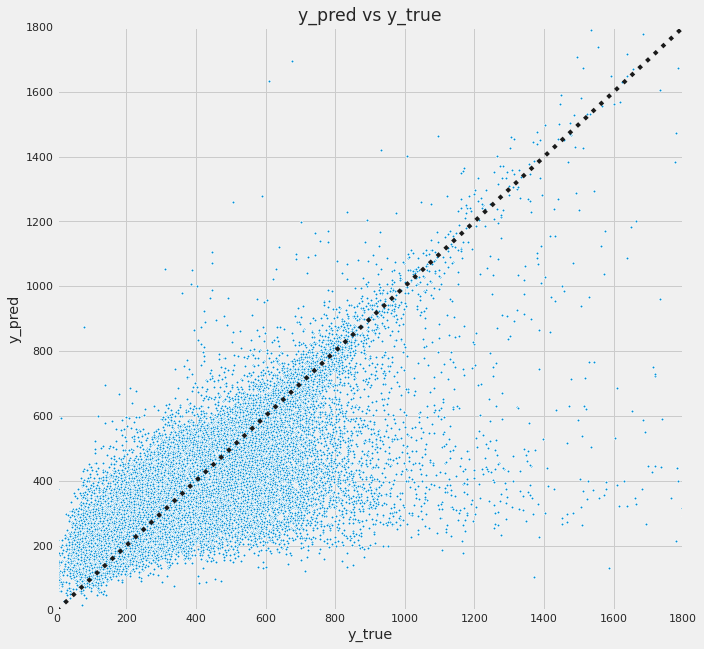

In [43]:
#@title Y1 - y_true vs y_pred
helpers.analyze_model.display_true_vs_pred(res_df, y_lim=60*30)
# Starting from 250s, the model under-estimates the duration
# The very dispersed points, below the diagonal line, explain why we have low R2.

Text(0.5, 1.0, 'y_pred vs standardized residual')

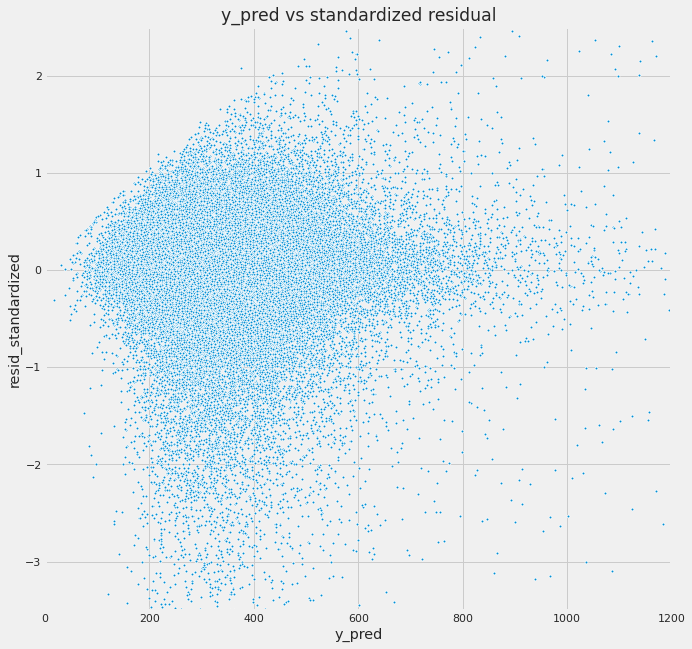

In [44]:
#@title Predicted vs Residual
ax = plt.subplot(111)
sns.scatterplot(x='y_pred', y='resid_standardized', data=res_df, s=8, ax=ax)
ax.set_xlim(0, 20*60)
ax.set_ylim(-3.5, 2.5)
ax.set_title('y_pred vs standardized residual')

# Residual = y_pred - y_actual, 
# positive=>overestimated, negative=>underestimated
# Residuals are strongly skewed on the negative side (underestimated)
# That is confirmed on the residual distribution curve and the qq-plot

In [45]:
# But in overall, the model did tend to overestimate
# Nb of points underestimated vs overestimated
np.sign(res_df.resid).value_counts()

# 40% of the predictions are overestimated.

1.000     42175
-1.000    30207
Name: resid, dtype: int64

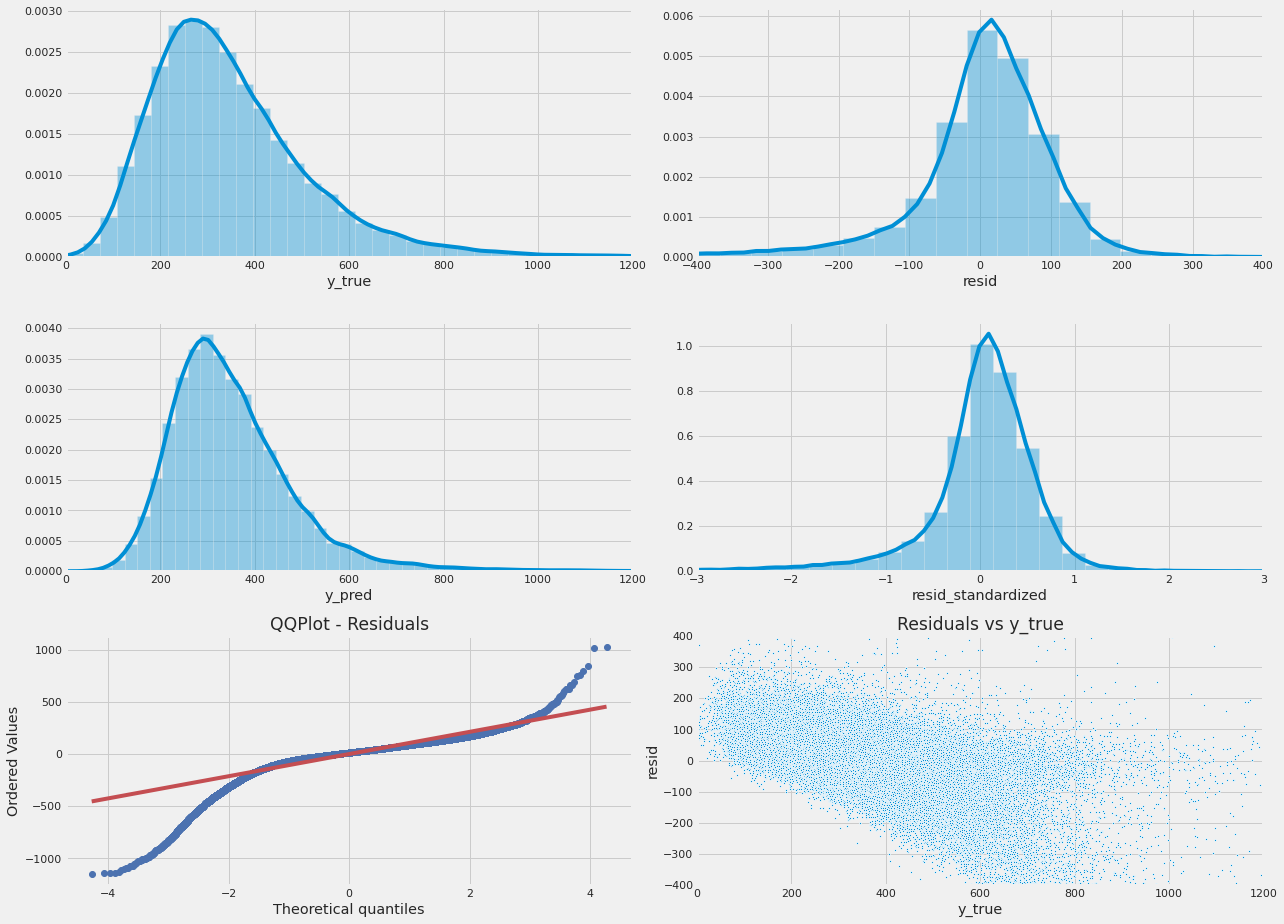

In [47]:
#@title model Y1 residuals
helpers.analyze_model.display_resid_distrib(res_df, y_lim=(0, 1200), res_lim=(-400,400))

In [48]:
# A strong skewness on the left tail (under-estimations)
# A strong kurtosis (very sharp central peak )
from scipy.stats import skew, kurtosis
skew(res_df.resid_standardized), kurtosis(res_df.resid_standardized)

(-44.89712551314252, 4675.929131019458)

In [49]:
#@title "R2 negative contribution"
# Creates a new column in residuals dataframe that represents the impact on R2
# sum of this variable will be SSres / SStot
# R2 = 1 - SSres/SStot
# https://en.wikipedia.org/wiki/Coefficient_of_determination

z = res_df.resid ** 2 / (res_df.y_true.var() * res_df.shape[0])
res_df.insert(0, 'r2_neg_contrib', z)
# R2:
1- z.sum(), r2_score(res_df.y_true, res_df.y_pred)

(0.42524646862416016, 0.425238527955596)

In [50]:
# sort by absolute(residual)
res_df.insert(0, 'resid_abs', res_df.resid.abs())
res_df = res_df.sort_values('resid_abs', ascending=False)
res_df.head(5)

resid_abs  r2_neg_contrib  y_true   y_pred      resid  resid_standardized  alert reason category  alert reason  intervention on public roads  floor  location of the event  longitude intervention  latitude intervention  emergency vehicle  rescue center  date key sélection  time key sélection status preceding selection  delta status preceding selection-selection  departed from its rescue center  longitude before departure  latitude before departure  delta position gps previous departure-departure  OSRM estimated distance  OSRM estimated duration  OSRM estimated distance from last observed GPS position  OSRM estimated duration from last observed GPS position  time elapsed between selection and last observed GPS position  updated OSRM estimated duration  selection_weekday  selection_month  selection_day  selection_hour  selection_is_holiday  OSRM_estimated_speed  departure2intervention_bearing  mid_point_lat  mid_point_lon                  waypoint1_name  waypoint1_lon  \
208599  21706.537           0.118   22722 1015.463 -21706.537            -121.665                      1          1922                             0      0                    139                   2.562                 48.832               4385           2458            20180227              110944                     Rentré                                       83194                                1                       2.458                     48.787                                            0.000                14673.200                  976.000                                              0.000                                                    0.000                                                    0.000                                        0.000                  1                2             27              11                 False                15.034                          56.542         48.809          2.510                         Missing          2.458   
183804  18311.846           0.084   18895  583.154 -18311.846            -102.638                      1          1922                             0      0                    139                   2.154                 48.838               4231           2476            20180418              132243                     Rentré                                       65801                                1                       2.237                     48.811                                            0.000                 8299.700                  752.200                                              0.000                                                    0.000                                                    0.000                                        0.000                  2                4             18              13                 False                11.034                         296.369         48.825          2.196                   Rue Lavoisier          2.238   
74454    7329.665           0.013    7777  447.335  -7329.665             -41.083                      3          2112                             0      0                    148                   2.227                 48.789               4461           2489            20180531              170808                     Rentré                                       12415                                1                       2.251                     48.785                                            0.000                 2920.400                  349.800                                              0.000                                                    0.000                                                    0.000                                        0.000                  3                5             31              17                 False                 8.349                         285.738         48.787          2.239     Avenue du Général de Gaulle          2.251   
9145     6574.513           0.011    7733 11

In [51]:
res_df.resid_abs.describe()

count   72382.000
mean       77.960
std       160.509
min         0.003
25%        22.422
50%        50.370
75%        95.079
max     21706.537
Name: resid_abs, dtype: float64

Text(0.5, 1.0, 'Cumulative density of abs(residual)')

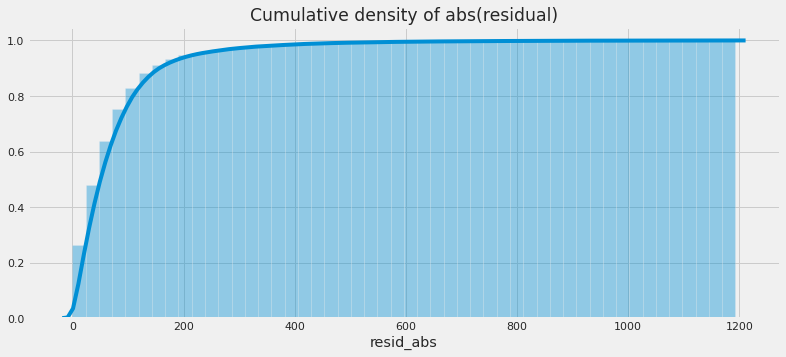

In [55]:
# Cumulative Density of abs(residual)
plt.figure(figsize=(12,5))
ax = plt.subplot(111)

sns.distplot(res_df.resid_abs[res_df.resid_abs < 20*60], 
             ax=ax,
             kde_kws={'cumulative': True},
             hist_kws={'cumulative': True})
plt.title('Cumulative density of abs(residual)')

# quasi totality of residuals are under 10mn (600 seconds)

In [56]:
# Cumulative Distribution (CDF)
# 92.34 % are under 3mn
n = res_df.shape[0]
l = [0.5, 1, 2, 3, 5, 10, 15, 20, 300]
for m in l:
  print(f'Proportion of samples with abs(residuals) < {m}mn: {res_df[res_df.resid_abs < m * 60].shape[0]*100/n:.2f} %')

Proportion of samples with abs(residuals) < 0.5mn: 32.50 %
Proportion of samples with abs(residuals) < 1mn: 56.63 %
Proportion of samples with abs(residuals) < 2mn: 83.11 %
Proportion of samples with abs(residuals) < 3mn: 92.34 %
Proportion of samples with abs(residuals) < 5mn: 97.12 %
Proportion of samples with abs(residuals) < 10mn: 99.40 %
Proportion of samples with abs(residuals) < 15mn: 99.77 %
Proportion of samples with abs(residuals) < 20mn: 99.88 %
Proportion of samples with abs(residuals) < 300mn: 100.00 %


In [57]:
# Survival Distribution (QDF)
# 7.66 % have residual > 3mn
for m in l:
  print(f'Proportion of samples with abs(residuals) > {m}mn: {res_df[res_df.resid_abs > m * 60].shape[0]*100/n:.2f} %')

Proportion of samples with abs(residuals) > 0.5mn: 67.50 %
Proportion of samples with abs(residuals) > 1mn: 43.37 %
Proportion of samples with abs(residuals) > 2mn: 16.89 %
Proportion of samples with abs(residuals) > 3mn: 7.66 %
Proportion of samples with abs(residuals) > 5mn: 2.88 %
Proportion of samples with abs(residuals) > 10mn: 0.60 %
Proportion of samples with abs(residuals) > 15mn: 0.23 %
Proportion of samples with abs(residuals) > 20mn: 0.12 %
Proportion of samples with abs(residuals) > 300mn: 0.00 %


In [58]:
ms = [0.5, 1, 2, 3, 5, 10, 15, 20, 300, 1200]
r2s = []
cum_pcts = []
n = res_df.shape[0]
for m in ms:
  z = res_df[res_df.resid_abs < m * 60]
  r2 = r2_score(z.y_true, z.y_pred)
  r2s.append(r2)
  pct = res_df[res_df.resid_abs < m * 60].shape[0]*100/n
  cum_pcts.append(pct)
  print(f'Samples with abs(residuals) < {m}mn, R2: {r2:.02f}, population pct: {pct:.03f} %')


Samples with abs(residuals) < 0.5mn, R2: 0.99, population pct: 32.497 %
Samples with abs(residuals) < 1mn, R2: 0.95, population pct: 56.630 %
Samples with abs(residuals) < 2mn, R2: 0.86, population pct: 83.115 %
Samples with abs(residuals) < 3mn, R2: 0.79, population pct: 92.342 %
Samples with abs(residuals) < 5mn, R2: 0.72, population pct: 97.119 %
Samples with abs(residuals) < 10mn, R2: 0.65, population pct: 99.403 %
Samples with abs(residuals) < 15mn, R2: 0.61, population pct: 99.771 %
Samples with abs(residuals) < 20mn, R2: 0.60, population pct: 99.876 %
Samples with abs(residuals) < 300mn, R2: 0.53, population pct: 99.997 %
Samples with abs(residuals) < 1200mn, R2: 0.43, population pct: 100.000 %


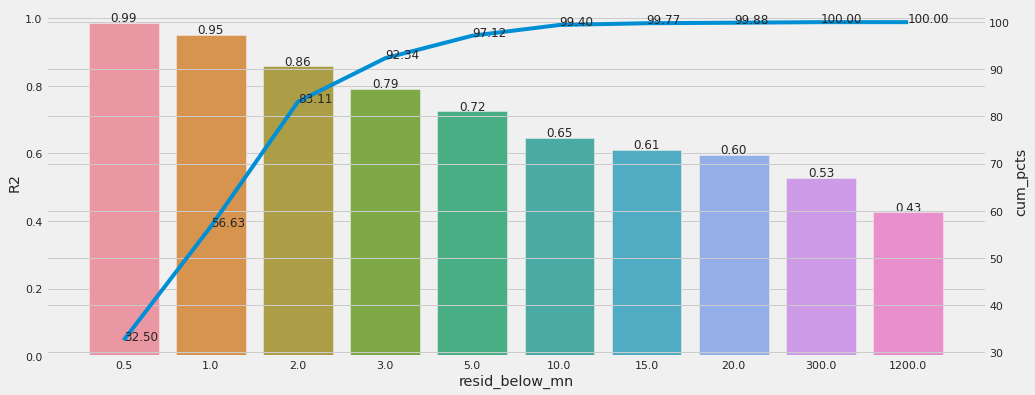

In [59]:
#@title How outliers affect R2 in test dataset?
# R2 vs Residuals
plt.figure(figsize=(15,6))
ax=plt.subplot(111)
tmp = pd.DataFrame({
    'id': list(range(len(ms))),
    'resid_below_mn': ms,
    'R2': r2s,
    'cum_pcts': cum_pcts})
barplt = sns.barplot(x='resid_below_mn', y='R2', 
            data=tmp,
            ax=ax)
for p in barplt.patches:
    barplt.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2.0, p.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 5),
                    textcoords = 'offset points',
                    )
ax2 = plt.twinx()
lineplt = sns.lineplot(x='id', y='cum_pcts', 
            data=tmp,
            ax=ax2
            )
for x, y in tmp[['id', 'cum_pcts']].values:
  lineplt.annotate(f'{y:.02f}',
                   (x, y),
                   )


# ax=plt.subplot(122)
# sns.barplot(x='resid_below_mn', y='cum_pcts', 
#             data=pd.DataFrame({'resid_below_mn': ms,
#                                'R2': r2s,
#                                'cum_pcts': cum_pcts}),
#             ax=ax
#             )

# 83% instances of test dataset have residual below 2 minutes (green bar)
# more than 90% have residual below 3 minutes (red bar)
# If we restricted the test dataset to those 90% percent instances, R2 would be close to 0.8 (~2x higher than the overall R2=4.2).

# That means there is a very small number of instances (10%) for which the model fails to predict with an error below 3 minutes.
# Furthermore, those instances have extreme outcome values that strongly decreases the model's R2.

This chart shows how R2 evolves if we evaluate the test dataset by subsetting the samples by their residual values. 

The colored bars represent the R2 values by cumulative bins of test data ordered by absolute value of residuals.
The first bar (blue) indicated the R2 on the test set if we only took samples having residuals under 0.5 minute.
The 2nd bar (orange) indicated the R2 on the test set if we only took samples having residuals under 1 minute.

The blue line indicates the corresponding proportion in the dataset.

So, if we take only samples having residuals below 2 minutes (green bar), it represents 83.11% of the test dataset population. It corresponds to R2=0.86.

That means the global R2 (0.42) is degraded mostly by a little portion of data.

In [60]:
# The 2 most extreme rows (out of 72382) account for 0.10 shift in R2
r2_score(res_df.iloc[2:, 2], res_df.iloc[2:, 3]) - 0.42524646862416016

0.10152185672039005

# Analyze outliers


In [61]:
# outilers: the 30 highest abs(residuals)
outliers = res_df.sort_values('resid_abs', ascending=False).iloc[:30]

In [62]:
outliers[['OSRM estimated distance',
          'y_true',	
          'y_pred',	
          'OSRM estimated duration',
          'resid_abs',	'r2_neg_contrib',	'resid',	'resid_standardized',
          ]].sort_values('OSRM estimated distance')

# First line: 4532s for 16m !

OSRM estimated distance  y_true   y_pred  OSRM estimated duration  resid_abs  r2_neg_contrib      resid  resid_standardized
194615                   16.400    4532 1254.889                    2.400   3277.111           0.003  -3277.111             -18.368
72366                   179.100    4085  138.720                   33.300   3946.280           0.004  -3946.280             -22.119
105389                  364.800    2533  167.267                   42.800   2365.733           0.001  -2365.733             -13.260
59935                   605.400    2465  191.466                  104.400   2273.534           0.001  -2273.534             -12.743
127559                  807.100    2431  262.224                  117.000   2168.776           0.001  -2168.776             -12.156
17785                   816.300    5660  323.396                  114.000   5336.604           0.007  -5336.604             -29.912
153718                  938.100    4110 1127.193                  133.500   2982.807           0.002  -2982.807             -16.719
127692                  956.100    2947  265.221                  141.900   2681.779           0.002  -2681.779             -15.031
86079                   979.400    2576  275.565                  131.300   2300.435           0.001  -2300.435             -12.894
116010                 1181.200    2453  284.202                  115.600   2168.798           0.001  -2168.798             -12.156
67117                  1325.700    2732  343.362                  174.200   2388.638           0.001  -2388.638             -13.388
189767                 1338.200    3702  331.941                  172.300   3370.059           0.003  -3370.059             -18.889
171454                 1409.700    3509  317.836                  160.200   3191.164           0.003  -3191.164             -17.886
209924                 1429.600    3595  322.350                  168.100   3272.650           0.003  -3272.650             -18.343
195722                 1529.600    3206  249.566                  200.100   2956.434           0.002  -2956.434             -16.571
163426                 1564.500    2511  279.848                  177.200   2231.152           0.001  -2231.152             -12.506
31892                  2527.900    2612  347.385                  258.000   2264.615           0.001  -2264.615             -12.693
58015                  2737.000    2593  383.862                  265.900   2209.138           0.001  -2209.138             -12.382
74454                  2920.400    7777  447.335                  349.800   7329.665           0.013  -7329.665             -41.083
3142                   3365.800   11489 7571.268                  311.000   3917.732           0.004  -3917.732             -21.959
192116                 3704.800    2704  461.122                  404.500   2242.878           0.001  -2242.878             -12.571
9145                   3946.900    7733 1158.487                  364.100   6574.513           0.011  -6574.513             -36.850
132159                 4295.400    3953  473.084                  437.300   3479.916           0.003  -3479.916             -19.505
180992                 4522.800    6270 1003.767                  540.900   5266.233           0.007  -5266.233             -29.517
17929                  4935.200    4506 1713.263                  538.700   2792.737           0.002  -2792.737             -15.653
106911                 5685.000    4203 1120.977                  512.800   3082.023           0.002  -3082.023             -17.275
183804                 8299.700   18895  583.154                  752.200  18311.846           0.084 -18311.846            -102.638
217711                 9006.600    4366 1422.427                  843.700   2943.573           0.002  -2943.573             -16.499
208599                14673.200   22722 1015.463                  976.000  21706.537           0.118 -21706.537            -121.665
123756                34052.400    5358 1707.717

In [ ]:
# Line 208599 and 183804: It took 6.3h and 5 hours!
22722/3600, 18895/3600

(6.3116666666666665, 5.248611111111111)

In [63]:
# Given a datapoint, returns an URL for google maps 
def make_googlemaps_lnk(x):
  x1_lat, x1_lon = x['latitude before departure'], x['longitude before departure']
  x2_lat, x2_lon = x['latitude intervention'], x['longitude intervention']
  print('OSRM estimated distance [m]:', x['OSRM estimated distance'])
  print('OSRM estimated duration [s]:', x['OSRM estimated duration'])
  print('y_true:', x.y_true)
  print('y_pred:', x.y_pred)
  url = f"https://www.google.com/maps/dir/?api=1&origin={x1_lat},{x1_lon}&destination={x2_lat},{x2_lon}&travelmode=driving"
  print(url)
  return url

make_googlemaps_lnk(res_df.iloc[1])
make_googlemaps_lnk(res_df.iloc[2])

OSRM estimated distance [m]: 8299.7
OSRM estimated duration [s]: 752.2
y_true: 18895
y_pred: 583.1539227406175
https://www.google.com/maps/dir/?api=1&origin=48.810966,2.237444&destination=48.838068,2.15429&travelmode=driving
OSRM estimated distance [m]: 2920.4
OSRM estimated duration [s]: 349.8
y_true: 7777
y_pred: 447.3348324590248
https://www.google.com/maps/dir/?api=1&origin=48.784871,2.251139&destination=48.789284,2.2273560000000003&travelmode=driving


'https://www.google.com/maps/dir/?api=1&origin=48.784871,2.251139&destination=48.789284,2.2273560000000003&travelmode=driving'

In [64]:
make_googlemaps_lnk(res_df.loc[208599])

OSRM estimated distance [m]: 14673.2
OSRM estimated duration [s]: 976.0
y_true: 22722
y_pred: 1015.4631082202072
https://www.google.com/maps/dir/?api=1&origin=48.786506,2.458175&destination=48.831556,2.561842&travelmode=driving


'https://www.google.com/maps/dir/?api=1&origin=48.786506,2.458175&destination=48.831556,2.561842&travelmode=driving'

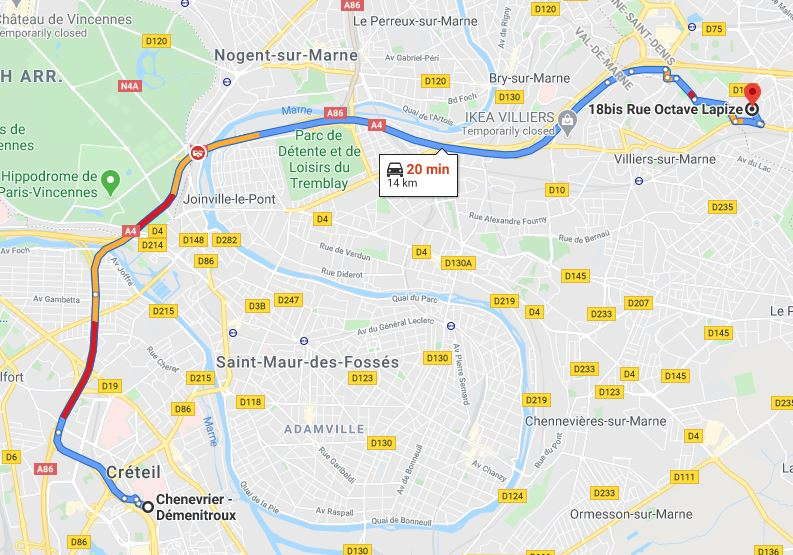

In [65]:
#@title outlier1: 6h for 14km in Paris est suburb
# https://www.google.com/maps/dir/?api=1&origin=48.786506,+2.458175&destination=48.831556,2.561842&travelmode=driving
from IPython.display import Image
Image(filename='images/outiler1_208599.JPG',width=600, height=400)

In [68]:
make_googlemaps_lnk(res_df.loc[74454])

OSRM estimated distance [m]: 2920.4
OSRM estimated duration [s]: 349.8
y_true: 7777
y_pred: 447.3348324590248
https://www.google.com/maps/dir/?api=1&origin=48.784871,2.251139&destination=48.789284,2.2273560000000003&travelmode=driving


'https://www.google.com/maps/dir/?api=1&origin=48.784871,2.251139&destination=48.789284,2.2273560000000003&travelmode=driving'

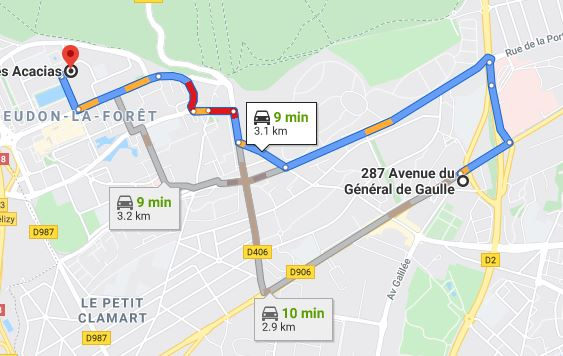

In [69]:
#@title outlier 2: 5 hours for 3.1km
# https://www.google.com/maps/dir/?api=1&origin=48.784871,2.251139&destination=48.789284,2.2273560000000003&travelmode=driving
Image(filename='images/outiler2_74454.JPG',width=600, height=400)

### How outliers is distributed in time ?
*   How many outliers per month or quarter (Poisson?) ?
*   How long between 2 outliers (exponential)?




In [70]:
# Outliers if resid_abs > 3 * std  (> 481s)
# Rare cases
resid_sd = res_df.resid_abs.std() # 160s
res_outliers = res_df[res_df.resid_abs > 3 * resid_sd]
res_outliers.shape, res_df.shape  # 721 outliers, 1%

((721, 70), (72382, 70))

selection_month  nb_outliers  nb_total  pct_outliers
0                 1           58      6691         0.867
1                 2           78      6013         1.297
2                 3           57      6764         0.843
3                 4           57      6237         0.914
4                 5           57      6781         0.841
5                 6           73      6750         1.081
6                 7           80      7055         1.134
7                 8           44      5668         0.776
8                10           67      6750         0.993
9                11           76      6685         1.137
10               12           74      6988         1.059

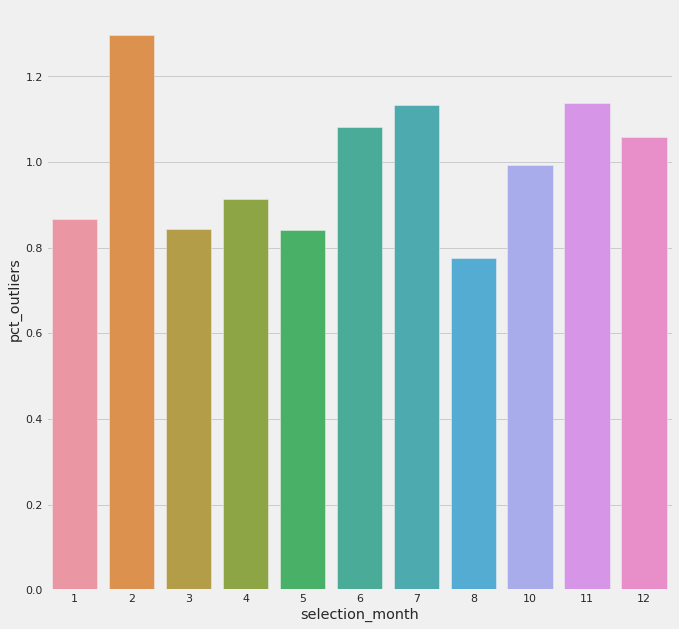

In [71]:
z = pd.concat([res_outliers.groupby('selection_month').size(),
           res_df.groupby('selection_month').size(),
           ], 
          axis=1,).reset_index().\
          rename({0: 'nb_outliers', 1: 'nb_total' }, axis=1)
z['pct_outliers'] = z.nb_outliers * 100 / z.nb_total
sns.barplot(x='selection_month', y='pct_outliers', data=z)
z

selection_month  nb_outliers  nb_total  pct_outliers
0   (0.989, 3.75]          193     19468         0.991
1     (3.75, 6.5]          187     19768         0.946
2     (6.5, 9.25]          124     12723         0.975
3    (9.25, 12.0]          217     20423         1.063

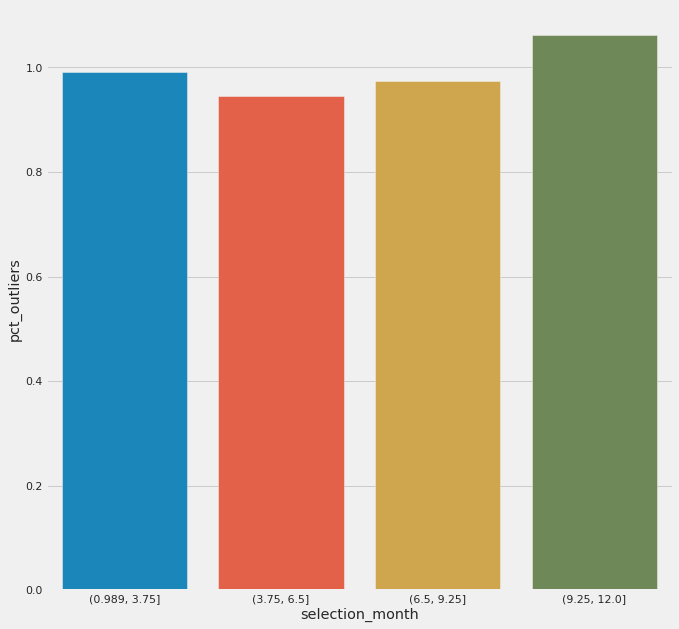

In [72]:
# Nb of outliers per quarter
bins_out = pd.cut(res_outliers['selection_month'], bins=4)
bins_all = pd.cut(res_df['selection_month'], bins=4)
# z = res_outliers.groupby(bins).size().reset_index()
z = pd.concat([res_outliers.groupby(bins_out).size(),
           res_df.groupby(bins_all).size(),
           ], 
          axis=1,).reset_index().\
          rename({0: 'nb_outliers', 1: 'nb_total' }, axis=1)
z['pct_outliers'] = z.nb_outliers * 100 / z.nb_total
sns.barplot(x='selection_month', y='pct_outliers', data=z)
z

## How are outliers distributed by region?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


longitude intervention  2.100  2.200  2.300  2.400  2.500  2.600
latitude intervention                                           
48.700                    nan    nan  3.618  1.299  0.380  1.266
48.800                    nan  1.784  1.255  0.567  0.526  0.365
48.900                    nan  1.354  1.135  0.909  0.885  1.532
49.000                    nan    nan  0.858  0.951  0.743  0.448

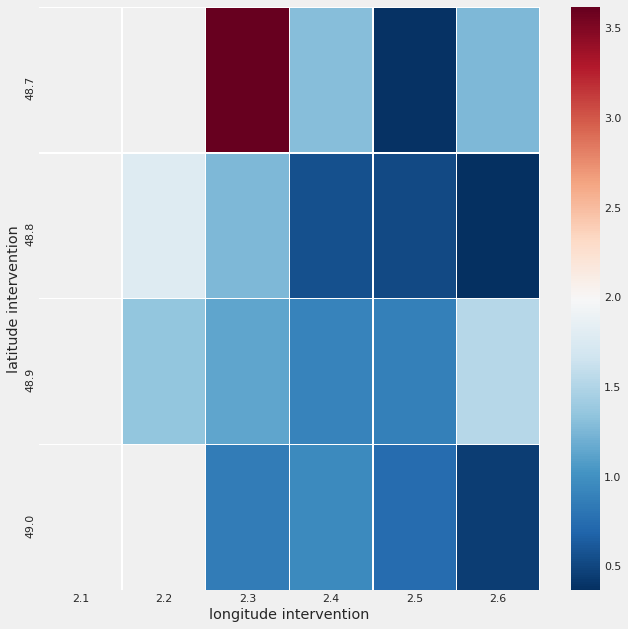

<Figure size 576x216 with 0 Axes>

In [73]:
# Pct of outliers per area
def display_heatmap2(outliers, all_df,
                     lat_colname, lon_colname, agg_fct, ax, **args):
  '''
  display_heatmap(outliers=xy_train_subset.sample(3000), 
                  all_df=res_df,
                  lat_colname='latitude intervention', 
                  lon_colname='longitude intervention', 
                  val_colname='delta selection-presentation',
                  agg_fct='median')
  '''
  # aggregate by latitude x longitude median
  # return the cross table latitude x longitude
  def group_by_area(data):
    z = data[[lat_colname, lon_colname]]
    z[lat_colname] = z[lat_colname].round(1)
    z[lon_colname] = z[lon_colname].round(1)
    z = z.groupby([lat_colname, lon_colname]).agg(agg_fct).reset_index()
    z.reset_index(inplace=True)
    # makes crosstable
    z = z.pivot(index=lat_colname, columns=lon_colname, values=0)
    return z

  z_outliers = group_by_area(outliers)
  z_all = group_by_area(all_df)
  z = z_outliers * 100/z_all
  
  # heatmap
  cmap = 'RdBu_r' #sns.cm.rocket_r
  plt.figure(figsize=(8,3))
  #ax = plt.subplot(111)
  g = sns.heatmap(z, cmap=cmap, ax=ax, linewidths=.5, **args)
  #plt.show()
  return z

# Outliers distribution per coord
outliers_map = display_heatmap2(
    outliers=res_outliers, 
    all_df=res_df,
    lat_colname='latitude intervention', 
    lon_colname='longitude intervention', 
    agg_fct='size',
    ax = plt.subplot(111))
outliers_map

In [74]:
np.nanstd(outliers_map.values), np.nanmean(outliers_map.values)

(0.7280348625963219, 1.1041914663109649)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


longitude intervention  2.100  2.200  2.300  2.400  2.500  2.600
latitude intervention                                           
48.700                    nan    nan  3.618  1.299  0.380  1.266
48.800                    nan  1.784  1.255  0.567  0.526  0.365
48.900                    nan  1.354  1.135  0.909  0.885  1.532
49.000                    nan    nan  0.858  0.951  0.743  0.448

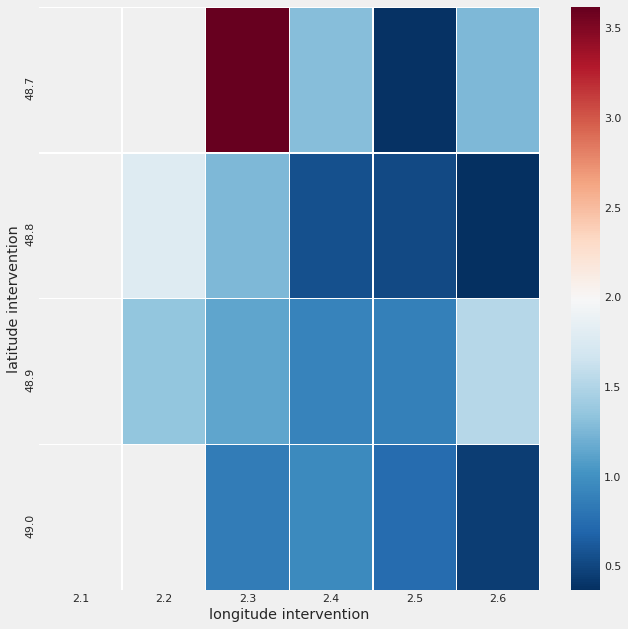

<Figure size 576x216 with 0 Axes>

In [77]:
all_map = display_heatmap2(
    outliers=res_outliers, 
    all_df=res_df, 
    lat_colname='latitude intervention', 
    lon_colname='longitude intervention', 
    agg_fct='size',
    ax = plt.subplot(111),
    )
all_map

# Can the model predict extreme values ?


In [79]:
# Is it possible to predict Y > 1800 with precision < 10mn ?
# Yes, but with few instances
res_df[(res_df['y_true'] > 60*30) & (res_df.resid_abs < 10*60)].head(15)

resid_abs  r2_neg_contrib  y_true   y_pred    resid  resid_standardized  alert reason category  alert reason  intervention on public roads  floor  location of the event  longitude intervention  latitude intervention  emergency vehicle  rescue center  date key sélection  time key sélection status preceding selection  delta status preceding selection-selection  departed from its rescue center  longitude before departure  latitude before departure  delta position gps previous departure-departure  OSRM estimated distance  OSRM estimated duration  OSRM estimated distance from last observed GPS position  OSRM estimated duration from last observed GPS position  time elapsed between selection and last observed GPS position  updated OSRM estimated duration  selection_weekday  selection_month  selection_day  selection_hour  selection_is_holiday  OSRM_estimated_speed  departure2intervention_bearing  mid_point_lat  mid_point_lon              waypoint1_name  waypoint1_lon  waypoint1_lat  \
139148    597.781           0.000    2077 1479.219 -597.781              -3.351                      9          2720                             0      0                    148                   2.388                 48.810               2419           2465            20180129               80821                     Rentré                                      260568                                1                       2.388                     48.810                                            0.000                   21.500                    3.200                                           2464.300                                                  245.100                                                 1565.430                                     1810.530                  0                1             29               8                 False                 6.719                         345.793         48.810          2.388              Rue Saint-Just          2.387         48.810   
31389     561.649           0.000    2362 1800.351 -561.649              -3.148                      1          1926                             0      0                    139                   2.551                 48.944               2329           2448            20180111              213343                     Rentré                                       11117                                1                       2.531                     48.808                                            0.000                22836.200                 1664.800                                            176.500                                                   29.000                                                 2487.367                                     2516.367                  3                1             11              21                 False                13.717                           5.373         48.876          2.541            Rue de Dunkerque          2.530         48.808   
34797     552.376           0.000    2260 2812.376  552.376               3.096                      9          2724                             0      0                    194                   2.318                 48.870               2903           2474            20181023              104400                     Rentré                                      568151                                1                       2.375                     48.823                                            0.000                 8667.500                  862.500                                              0.000                                                    0.000                                                    0.000                                        0.000                  1               10             23              10                 False                10.049                         321.925         48.846          2.346             Avenue Boutroux          2.375         48.822   
54953   

In [80]:
# The model does not know to predict extreme values (more than 30mn)...
# Among the instances having y > 30mn, only 30% of them are predicted with values > 30mn.
# That means 70% of them are under-estimated.
res_df[res_df['y_pred'] > 60*30].shape, res_df[res_df['y_true'] > 60*30].shape

((29, 70), (103, 70))

In [81]:
# The 2 worse cases
res_df.loc[[189767, 194615]]

resid_abs  r2_neg_contrib  y_true   y_pred     resid  resid_standardized  alert reason category  alert reason  intervention on public roads  floor  location of the event  longitude intervention  latitude intervention  emergency vehicle  rescue center  date key sélection  time key sélection status preceding selection  delta status preceding selection-selection  departed from its rescue center  longitude before departure  latitude before departure  delta position gps previous departure-departure  OSRM estimated distance  OSRM estimated duration  OSRM estimated distance from last observed GPS position  OSRM estimated duration from last observed GPS position  time elapsed between selection and last observed GPS position  updated OSRM estimated duration  selection_weekday  selection_month  selection_day  selection_hour  selection_is_holiday  OSRM_estimated_speed  departure2intervention_bearing  mid_point_lat  mid_point_lon    waypoint1_name  waypoint1_lon  waypoint1_lat  \
189767   3370.059           0.003    3702  331.941 -3370.059             -18.889                      3          2162                             0      1                    136                   2.382                 48.856               4389           2446            20181130               91757                     Rentré                                        1350                                1                       2.384                     48.848                                            0.000                 1338.200                  172.300                                              0.000                                                    0.000                                                    0.000                                        0.000                  4               11             30               9                 False                 7.767                         348.470         48.852          2.383      Rue Chaligny          2.384         48.848   
194615   3277.111           0.003    4532 1254.889 -3277.111             -18.368                      9          2720                             0      0                    170                   2.530                 48.808               5965           2448            20180206               83504                     Rentré                                       62614                                1                       2.531                     48.808                                            0.000                   16.400                    2.400                                              0.000                                                    0.000                                                    0.000                                        0.000                  1                2              6               8                 False                 6.833                         254.465         48.808          2.531  Rue de Dunkerque          2.530         48.808   

                     waypoint2_name  waypoint2_lon  waypoint2_lat    waypoint3_name  waypoint3_lon  waypoint3_lat               waypoint4_name  waypoint4_lon  waypoint4_lat  paris2intervention_bearing  paris2intervention_km  paris2departure_bearing  paris2departure_km  paris2mid_point_bearing  paris2mid_point_km  paris2waypoint1_bearing  paris2waypoint1_km  paris2waypoint2_bearing  paris2waypoint2_km  GPS_Tracks_records  GPS_Tracks_duration_hr  GPS_Tracks_distance_km  GPS_Tracks_mean_kmh  GPS_Tracks_std_kmh  GPS_Tracks_80pc_kmh vehicule_type vehicule_ownrer  speed_mean_kmh  intervention_place  
189767  Rue François de Neufchâteau          2.382         48.856      Rue Chaligny          0.000          0.000  Rue François de Neufchâteau          0.000          0.000                      91.923                  2.168                  113.118               2.562                  103.416               2.325                  113.321               2.531                   92.108               2.171                   0         

In [ ]:
# # 3702s for 1.3 km !
make_googlemaps_lnk(res_df.loc[189767])

OSRM estimated distance [m]: 1338.2
OSRM estimated duration [s]: 172.3
y_true: 3702
y_pred: 331.9412421688554
https://www.google.com/maps/dir/?api=1&origin=48.847571,2.3843240000000003&destination=48.855944,2.381728&travelmode=driving


'https://www.google.com/maps/dir/?api=1&origin=48.847571,2.3843240000000003&destination=48.855944,2.381728&travelmode=driving'

In [ ]:
# 4532s for 2.4m !
make_googlemaps_lnk(res_df.loc[194615])

OSRM estimated distance [m]: 16.4
OSRM estimated duration [s]: 2.4
y_true: 4532
y_pred: 1254.889389754253
https://www.google.com/maps/dir/?api=1&origin=48.807955,2.531216&destination=48.807797,2.530353&travelmode=driving


'https://www.google.com/maps/dir/?api=1&origin=48.807955,2.531216&destination=48.807797,2.530353&travelmode=driving'

In [82]:
y_train[y_train[Y_NAMES[1]] > 45*60].shape, y_train_sp[y_train_sp[Y_NAMES[1]] > 45*60].shape, y_test_sp[y_test_sp[Y_NAMES[1]] > 45*60].shape

((112, 4), (84, 4), (28, 4))

In [83]:
res_df[res_df['y_true'] > 60*45].describe()

resid_abs  r2_neg_contrib    y_true   y_pred      resid  resid_standardized  alert reason category  alert reason  intervention on public roads  floor  location of the event  longitude intervention  latitude intervention  emergency vehicle  rescue center  date key sélection  time key sélection  delta status preceding selection-selection  departed from its rescue center  longitude before departure  latitude before departure  delta position gps previous departure-departure  OSRM estimated distance  OSRM estimated duration  OSRM estimated distance from last observed GPS position  OSRM estimated duration from last observed GPS position  time elapsed between selection and last observed GPS position  updated OSRM estimated duration  selection_weekday  selection_month  selection_day  selection_hour  OSRM_estimated_speed  departure2intervention_bearing  mid_point_lat  mid_point_lon  waypoint1_lon  waypoint1_lat  waypoint2_lon  waypoint2_lat  waypoint3_lon  waypoint3_lat  waypoint4_lon  \
count     28.000          28.000    28.000   28.000     28.000              28.000                 28.000        28.000                        28.000 28.000                 28.000                  28.000                 28.000             28.000         28.000              28.000              28.000                                      28.000                           28.000                      28.000                     28.000                                           28.000                   28.000                   28.000                                             28.000                                                   28.000                                                   28.000                                       28.000             28.000           28.000         28.000          28.000                28.000                          28.000         28.000         28.000         28.000         28.000         28.000         28.000         28.000         28.000         28.000   
mean    4274.260           0.010  5690.929 1421.738  -4269.191             -23.929                  3.821      2217.964                         0.071  1.107                143.250                   2.354                 48.859           4317.107      30735.214        20180500.321          144265.964                                   83713.107                            1.000                       2.337                     48.859                                            0.000                 5207.282                  449.882                                           1164.500                                                   91.936                                                 1670.074                                     1762.009              2.679            4.857         14.607          14.107                 9.588                         165.142         48.859          2.346          2.337         48.859          2.354         48.859          0.849         17.452          0.853   
std     4775.222           0.026  4705.774 1599.140   4779.922              26.791                  2.465       239.550                         0.262  2.455                 18.777                   0.104                  0.044           1277.169      83095.451             360.999           55003.198                                  182318.874                            0.000                       0.108                      0.047                                            0.000                 6739.947                  444.253                                           3983.447                                                  243.903                                                 2854.257                                     2965.911              1.786            3.577          9.175           5.466                 2.778                          99.128          0.043          0.099          0.108          0.047          0.104          0.044          1.162         23.844          1.167   
min

# Are outliers predictable?

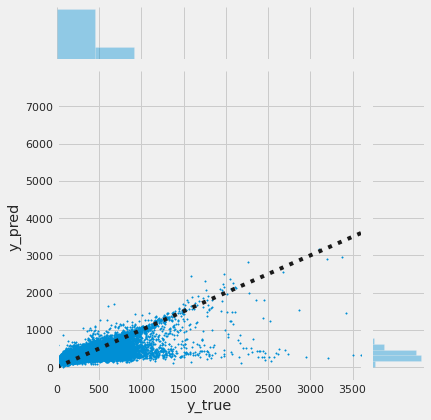

In [84]:
# from 5mn, most of predictions are under-estimated
i = 0
g = sns.jointplot(y='y_pred', x='y_true', 
                  data=res_df[res_df.y_true > i*60],
                  xlim=(0, 3600),
                  s=2)

x0, x1 = g.ax_joint.get_xlim()
# y0, y1 = g.ax_joint.get_ylim()
# lims = [max(x0, y0), min(x1, y1)]
lims = [x1, 0]
g.ax_joint.plot(lims, lims, ':k') 

In [ ]:
# Outliers if resid_abs > 30mn
# Rare cases
res_df[res_df.resid_abs > 15 * 60].shape, res_df.shape

((166, 70), (72382, 70))

In [85]:
# Only 0.2% of cases where resid_abs > 15mn.
166 / 72382

0.0022933878588599376

In [86]:
res_df.head(2)

resid_abs  r2_neg_contrib  y_true   y_pred      resid  resid_standardized  alert reason category  alert reason  intervention on public roads  floor  location of the event  longitude intervention  latitude intervention  emergency vehicle  rescue center  date key sélection  time key sélection status preceding selection  delta status preceding selection-selection  departed from its rescue center  longitude before departure  latitude before departure  delta position gps previous departure-departure  OSRM estimated distance  OSRM estimated duration  OSRM estimated distance from last observed GPS position  OSRM estimated duration from last observed GPS position  time elapsed between selection and last observed GPS position  updated OSRM estimated duration  selection_weekday  selection_month  selection_day  selection_hour  selection_is_holiday  OSRM_estimated_speed  departure2intervention_bearing  mid_point_lat  mid_point_lon waypoint1_name  waypoint1_lon  waypoint1_lat  \
208599  21706.537           0.118   22722 1015.463 -21706.537            -121.665                      1          1922                             0      0                    139                   2.562                 48.832               4385           2458            20180227              110944                     Rentré                                       83194                                1                       2.458                     48.787                                            0.000                14673.200                  976.000                                              0.000                                                    0.000                                                    0.000                                        0.000                  1                2             27              11                 False                15.034                          56.542         48.809          2.510        Missing          2.458         48.786   
183804  18311.846           0.084   18895  583.154 -18311.846            -102.638                      1          1922                             0      0                    139                   2.154                 48.838               4231           2476            20180418              132243                     Rentré                                       65801                                1                       2.237                     48.811                                            0.000                 8299.700                  752.200                                              0.000                                                    0.000                                                    0.000                                        0.000                  2                4             18              13                 False                11.034                         296.369         48.825          2.196  Rue Lavoisier          2.238         48.811   

           waypoint2_name  waypoint2_lon  waypoint2_lat waypoint3_name  waypoint3_lon  waypoint3_lat     waypoint4_name  waypoint4_lon  waypoint4_lat  paris2intervention_bearing  paris2intervention_km  paris2departure_bearing  paris2departure_km  paris2mid_point_bearing  paris2mid_point_km  paris2waypoint1_bearing  paris2waypoint1_km  paris2waypoint2_bearing  paris2waypoint2_km  GPS_Tracks_records  GPS_Tracks_duration_hr  GPS_Tracks_distance_km  GPS_Tracks_mean_kmh  GPS_Tracks_std_kmh  GPS_Tracks_80pc_kmh vehicule_type vehicule_ownrer  speed_mean_kmh  intervention_place  
208599  Rue Octave Lapize          2.562         48.832        Missing          0.000          0.000  Rue Octave Lapize          0.000          0.000                     100.209                 15.638                  135.091              11.015                  114.543              12.734                  135.051              11.024                  100.207              15.639                   0                   0.000                   0.000             

In [87]:
m, s = res_df.resid_abs.mean(), res_df.resid_abs.std()
res_x = res_df.iloc[:, 6:]
res_y = (res_df.resid_abs > (m + 2*s))
res_y = res_y.astype(int)

In [88]:
res_x.shape

(72382, 64)

In [89]:
res_x_train, res_x_test, res_y_train, res_y_test = train_test_split(
    res_x,
    res_y, 
    test_size=0.20, 
    random_state=0,   #42
    )
res_x_train.shape, res_x_test.shape

((57905, 64), (14477, 64))

In [90]:
res_y_train.value_counts()

0    56993
1      912
Name: resid_abs, dtype: int64

In [92]:
res_y_test.value_counts()

0    14263
1      214
Name: resid_abs, dtype: int64

In [93]:
%%time
clf=catboost.CatBoostClassifier(
    cat_features=cat_features_idx,
    early_stopping_rounds = 20)
clf.fit(res_x_train, 
        res_y_train,
        eval_set=(res_x_test, res_y_test),
        verbose=100,
        )

Learning rate set to 0.086357
0:	learn: 0.5351056	test: 0.5347440	best: 0.5347440 (0)	total: 125ms	remaining: 2m 4s
100:	learn: 0.0728438	test: 0.0714993	best: 0.0714902 (99)	total: 13.3s	remaining: 1m 58s
200:	learn: 0.0700889	test: 0.0710533	best: 0.0710477 (197)	total: 29.9s	remaining: 1m 58s
300:	learn: 0.0674865	test: 0.0707535	best: 0.0707535 (300)	total: 43s	remaining: 1m 39s
400:	learn: 0.0650321	test: 0.0705847	best: 0.0705654 (383)	total: 56.3s	remaining: 1m 24s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.0705654089
bestIteration = 383

Shrink model to first 384 iterations.
CPU times: user 3min 7s, sys: 14.1 s, total: 3min 21s
Wall time: 1min 2s


In [94]:
clf.predict(res_x_test)

array([0, 0, 0, ..., 0, 0, 0])

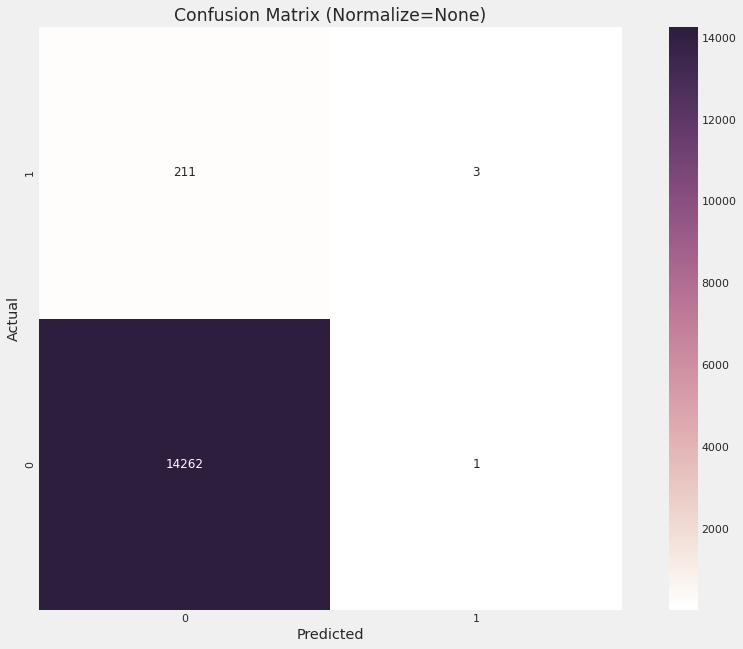

In [95]:
from helpers import analyze_model
import importlib
importlib.reload(analyze_model)

analyze_model.plot_confusion_matrix(
    classifier=clf, 
    x_test=res_x_test, 
    y_true=res_y_test, 
    normalize=None
    )
# Too many false negatives (211)
# Too little true positive (3)

In [96]:
clf.get_feature_importance(prettified=True).head(15)

Feature Id  Importances
0                                       waypoint3_lon        6.386
1                              GPS_Tracks_distance_km        5.518
2                                       waypoint3_lat        4.109
3                     updated OSRM estimated duration        3.702
4                              GPS_Tracks_duration_hr        3.611
5                                  date key sélection        3.446
6                      departure2intervention_bearing        3.328
7                                      speed_mean_kmh        3.079
8                                  GPS_Tracks_std_kmh        2.917
9                               alert reason category        2.650
10                                       alert reason        2.621
11                            OSRM estimated duration        2.356
12                            OSRM estimated distance        2.318
13                                 time key sélection        2.260
14  OSRM estimated duration from last observed GPS...        2.209

In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy (correct predictions / Total predictions)=',
      accuracy_score(y_true=res_y_test,
                    y_pred=clf.predict(res_x_test)
                    )
)
print('Recall (TP/(TP + FN))=',
      recall_score(y_true=res_y_test,
                    y_pred=clf.predict(res_x_test)
                    )
)
print('Precision (TP / (TP + FP))=',
      precision_score(y_true=res_y_test,
                    y_pred=clf.predict(res_x_test)
                    )
)

# Very low recall: most of outliers cannot be detected!

Accuracy (correct predictions / Total predictions)= 0.9853560820612005
Recall (TP/(TP + FN))= 0.014018691588785047
Precision (TP / (TP + FP))= 0.75


# How far are the outliers from the centroids of the inliers?
Are they close to the train dataset prototypes (cluster centroids) ?
https://christophm.github.io/interpretable-ml-book/proto.html#proto<br>
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [103]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [104]:
# Load onehot encoded data
DATA_DIR = 'data/'
#x_train = pickle.load(open(DATA_DIR + 'x_train.beforeOneHot.pickle', 'rb'))
x_train_1hot = pd.read_csv(DATA_DIR+'prepared/x_train_1hot.csv.zip', compression='zip')
x_train_1hot[x_train_1hot.select_dtypes(bool).columns] = x_train_1hot.select_dtypes(bool).astype('float')
x_train_1hot_sp = x_train_1hot.loc[x_train_sp.index,:]
x_test_1hot_sp = x_train_1hot.loc[x_test_sp.index,:]

In [105]:
# Standard Scaling data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
# Do not standardize one hot encoded columns
to_standardize = [c for c in x_train_1hot_sp.columns if not c.startswith('H_') and c != 'selection_is_holiday']
# to_standardize = x_train_1hot_sp.columns
x_train_1hot_sp[to_standardize] = sc.fit_transform(x_train_1hot_sp[to_standardize])
x_test_1hot_sp[to_standardize] = sc.transform(x_test_1hot_sp[to_standardize])

In [106]:
# Finds best nb of clusters
best_silhouette_avg = -1
best_clusterer = None
res = []
for n_clusters in [2, 4, 8, 12, 16]:
  clusterer = KMeans(n_clusters=n_clusters, random_state=42)
  X = x_train_1hot_sp.head(60000)
  # X = x_train_sp.select_dtypes('number').head(100).values
  cluster_labels = clusterer.fit_predict(X)
  silhouette_avg = silhouette_score(X, cluster_labels)
  print(f'{n_clusters} clusters, silhouette: {silhouette_avg}')
  if silhouette_avg > best_silhouette_avg:
    best_silhouette_avg = silhouette_avg
    best_clusterer = clusterer
  res.append([n_clusters, silhouette_avg])

pd.DataFrame(res, columns=['n_clusters', 'silhouette_avg'])
# silhouette_score: The best value is 1 and the worst value is -1. 
# Values near 0 indicate overlapping clusters. 
# Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

2 clusters, silhouette: 0.1889903091786429
4 clusters, silhouette: 0.1329544895402461
8 clusters, silhouette: 0.1469711299167748
12 clusters, silhouette: 0.1306028635308247
16 clusters, silhouette: 0.11150437390279859


n_clusters  silhouette_avg
0           2           0.189
1           4           0.133
2           8           0.147
3          12           0.131
4          16           0.112

In [107]:
# Best clustering: 2 clusters
# with centers:
best_clusterer.cluster_centers_

array([[-8.52768673e-02,  1.08085694e+00, -2.86151944e-02, ...,
         3.28299409e-04,  5.47165682e-05,  5.47165682e-05],
       [ 4.15682817e-02, -4.64976839e-01,  1.81852768e-02, ...,
        -8.66277536e-17,  1.71778282e-18,  1.71778282e-18]])

In [ ]:
# Inertia : https://stats.stackexchange.com/questions/78313/clustering-inertia-formula-in-scikit-learn
# sum of squared distance for each point to it's closest centroid
best_clusterer.inertia_

3053934.2088079047

In [108]:
# From the 10 worse predicted instances, 
# computes their distances, d1, d2, to the respective cluster centers
c1 = best_clusterer.cluster_centers_[0]
c2 = best_clusterer.cluster_centers_[1]
for i in range(10):
  x = x_test_1hot_sp.loc[res_df.index].iloc[i]
  d1, d2 = np.linalg.norm(x-c1),  np.linalg.norm(x-c2)
  print(i, d1, d2)

0 11.169238840862064 13.384689767730098
1 10.420597200933567 9.141537449347373
2 8.493272079167001 6.23113852812351
3 42.3003175299654 44.20152842155065
4 9.234754531231001 5.406468563728055
5 11.715953166489324 9.170385473043988
6 7.479828120332924 5.603971498114661
7 96.16972459323942 97.80218420810631
8 27.786790738683067 28.396820326274202
9 9.367091321013765 6.799541437791506


In [109]:
# For the 10 best predicted
n = x_test_1hot_sp.shape[0]-1
for i in range(10):
  x = x_test_1hot_sp.loc[res_df.index].iloc[n-i]
  d1, d2 = np.linalg.norm(x-c1),  np.linalg.norm(x-c2)
  print(i, d1, d2)

0 9.104946506911704 8.441031396537717
1 6.435804882991738 6.961909987780905
2 7.532902874695293 8.260218724864112
3 9.461398685802115 7.755718260392221
4 7.547692724127252 5.740077069547556
5 11.425866341590618 11.708084751863124
6 8.464647158922483 5.399422333075224
7 6.688928417770973 8.406536427563053
8 9.093300727132423 7.040735842537539
9 7.8154398689494435 5.4685612447353815


In [110]:
# Divides the test instances into 2 sets
# x_worse_predicted = top 300 worse predicted
# x_best_predicted = top 300 best predicted
# See how their distances to the centroids centers are distributed
x_worse_predicted = x_test_1hot_sp.loc[res_df.index].iloc[:300]
x_best_predicted = x_test_1hot_sp.loc[res_df.index].iloc[-300:]
dist_worse_predicted = {}
dist_best_predicted = {}
for i in range(2):
  dist_worse_predicted[f'distance2cluster{i}'] = \
    np.linalg.norm(x_worse_predicted - best_clusterer.cluster_centers_[i], 
                 axis=1)
  dist_best_predicted[f'distance2cluster{i}'] = \
    np.linalg.norm(x_best_predicted - best_clusterer.cluster_centers_[i], 
                 axis=1)


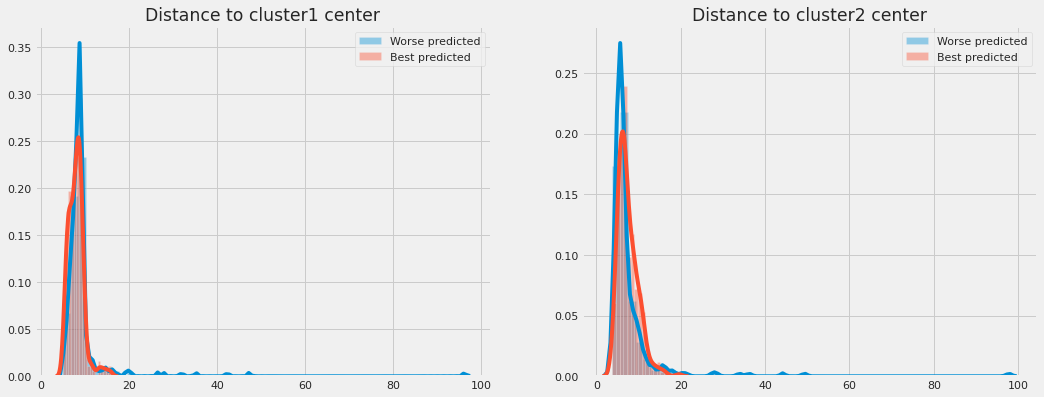

In [111]:
plt.figure(figsize=(16, 6))
ax = plt.subplot(121)
sns.distplot(dist_worse_predicted[f'distance2cluster0'], ax=ax, label='Worse predicted',)
sns.distplot(dist_best_predicted[f'distance2cluster0'], ax=ax, label='Best predicted',)
# ax.set_xlim(0, 600)
# ax.set_title(Y_NAMES[0])
ax.set_title('Distance to cluster1 center')
ax.legend()

ax = plt.subplot(122)
sns.distplot(dist_worse_predicted[f'distance2cluster1'], ax=ax, label='Worse predicted',)
sns.distplot(dist_best_predicted[f'distance2cluster1'], ax=ax, label='Best predicted',)
# ax.set_xlim(0, 600)
# ax.set_title(Y_NAMES[0])
ax.set_title('Distance to cluster2 center')
ax.legend()

In [112]:
dist_df = \
  pd.concat([
      pd.DataFrame({'set': ['worse_predicted']*300, **dist_worse_predicted}),
      pd.DataFrame({'set': ['best_predicted']*300, **dist_best_predicted}),
  ], axis=0, ignore_index=True)
dist_df.groupby('set').describe()
# The 2 sets have very close median distances to both cluster.
# However, few of them are very far the center (see max distances)

distance2cluster0                                            distance2cluster1                                           
                            count  mean   std   min   25%   50%   75%    max             count  mean   std   min   25%   50%   75%    max
set                                                                                                                                      
best_predicted            300.000 7.969 1.764 4.943 6.663 7.964 8.816 15.887           300.000 7.491 2.395 3.731 5.743 6.890 8.795 19.545
worse_predicted           300.000 9.350 6.676 4.777 7.474 8.523 9.098 96.170           300.000 7.727 7.309 3.620 5.248 5.975 7.682 97.802

In [113]:
# Which instances have distance > 50 from the centers ?
res_df.iloc[:300][dist_worse_predicted['distance2cluster0'] > 50]
# The partucularity of this instance consist in its feature on GPS tracking: GPS_Tracks_records=123,	GPS_Tracks_duration_hr=2.58, GPS_Tracks_distance_km=27.61
# It was unsual to have so extreme GPS tracking info 

resid_abs  r2_neg_contrib  y_true   y_pred     resid  resid_standardized  alert reason category  alert reason  intervention on public roads  floor  location of the event  longitude intervention  latitude intervention  emergency vehicle  rescue center  date key sélection  time key sélection status preceding selection  delta status preceding selection-selection  departed from its rescue center  longitude before departure  latitude before departure  delta position gps previous departure-departure  OSRM estimated distance  OSRM estimated duration  OSRM estimated distance from last observed GPS position  OSRM estimated duration from last observed GPS position  time elapsed between selection and last observed GPS position  updated OSRM estimated duration  selection_weekday  selection_month  selection_day  selection_hour  selection_is_holiday  OSRM_estimated_speed  departure2intervention_bearing  mid_point_lat  mid_point_lon           waypoint1_name  waypoint1_lon  waypoint1_lat  \
3142   3917.732           0.004   11489 7571.268 -3917.732             -21.959                      3          2113                             0      0                    139                   2.480                 48.856               5715           2509            20180522              122715                     Rentré                                        2356                                1                       2.452                     48.847                                            0.000                 3365.800                  311.000                                           3361.000                                                  310.300                                                11574.527                                    11884.827                  1                5             22              12                 False                10.823                          62.398         48.851          2.466  Avenue des Murs du Parc          2.452         48.847   

     waypoint2_name  waypoint2_lon  waypoint2_lat           waypoint3_name  waypoint3_lon  waypoint3_lat waypoint4_name  waypoint4_lon  waypoint4_lat  paris2intervention_bearing  paris2intervention_km  paris2departure_bearing  paris2departure_km  paris2mid_point_bearing  paris2mid_point_km  paris2waypoint1_bearing  paris2waypoint1_km  paris2waypoint2_bearing  paris2waypoint2_km  GPS_Tracks_records  GPS_Tracks_duration_hr  GPS_Tracks_distance_km  GPS_Tracks_mean_kmh  GPS_Tracks_std_kmh  GPS_Tracks_80pc_kmh vehicule_type vehicule_ownrer  speed_mean_kmh  intervention_place  
3142  Rue Jean Macé          2.480         48.856  Avenue des Murs du Parc          2.452         48.847  Rue Jean Macé          2.480         48.856                      90.390                  9.363                   98.658               7.434                   94.049               8.377                   98.400               7.438                   90.478               9.362                 123                   2.580                  27.615                9.948              12.645               19.775          VSAV            BSPP          34.267                 214

In [114]:
x_train_sp[[c for c in x_train_sp.columns if c.startswith('GPS_Tracks')]].describe()

GPS_Tracks_records  GPS_Tracks_duration_hr  GPS_Tracks_distance_km  GPS_Tracks_mean_kmh  GPS_Tracks_std_kmh  GPS_Tracks_80pc_kmh
count          146955.000              146955.000              146955.000           146955.000          146955.000           146955.000
mean                1.313                   0.021                   2.939               64.054              41.371               80.364
std                 2.537                   0.045                 206.910             5562.510            3784.069             6832.682
min                 0.000                   0.000                   0.000                0.000               0.000                0.000
25%                 0.000                   0.000                   0.000                0.000               0.000                0.000
50%                 0.000                   0.000                   0.000                0.000               0.000                0.000
75%                 2.000                   0.020                   0.376                9.339               0.000               12.620
max               127.000                   2.537               34713.708          1034732.349          893654.320          1137459.865

In [115]:
# Which instances have distance > 40 from the centers ?
res_df.iloc[:300][dist_worse_predicted['distance2cluster0'] > 40]
# The partucularity of this instance consist in its feature on GPS tracking: GPS_Tracks_records=123,	GPS_Tracks_duration_hr=2.58, GPS_Tracks_distance_km=27.61
# It is unsual to have so extreme GPS tracking info

resid_abs  r2_neg_contrib  y_true   y_pred     resid  resid_standardized  alert reason category  alert reason  intervention on public roads  floor  location of the event  longitude intervention  latitude intervention  emergency vehicle  rescue center  date key sélection  time key sélection status preceding selection  delta status preceding selection-selection  departed from its rescue center  longitude before departure  latitude before departure  delta position gps previous departure-departure  OSRM estimated distance  OSRM estimated duration  OSRM estimated distance from last observed GPS position  OSRM estimated duration from last observed GPS position  time elapsed between selection and last observed GPS position  updated OSRM estimated duration  selection_weekday  selection_month  selection_day  selection_hour  selection_is_holiday  OSRM_estimated_speed  departure2intervention_bearing  mid_point_lat  mid_point_lon                  waypoint1_name  waypoint1_lon  \
9145    6574.513           0.011    7733 1158.487 -6574.513             -36.850                      3          2162                             0      3                    139                   2.494                 48.930               4318           2437            20180531              170542                     Rentré                                        4496                                1                       2.515                     48.947                                            0.000                 3946.900                  364.100                                           2128.500                                                  306.000                                                 7817.013                                     8123.013                  3                5             31              17                 False                10.840                         219.190         48.939          2.504  Avenue John Fitzgerald Kennedy          2.516   
3142    3917.732           0.004   11489 7571.268 -3917.732             -21.959                      3          2113                             0      0                    139                   2.480                 48.856               5715           2509            20180522              122715                     Rentré                                        2356                                1                       2.452                     48.847                                            0.000                 3365.800                  311.000                                           3361.000                                                  310.300                                                11574.527                                    11884.827                  1                5             22              12                 False                10.823                          62.398         48.851          2.466         Avenue des Murs du Parc          2.452   
31618    915.418           0.000    5342 4426.582  -915.418              -5.131                      5          2311                             0      0                    206                   2.490                 48.924               2766           2454            20181016              113540                     Rentré                                      168586                                1                       2.542                     48.904                                            0.000                 5195.700                  494.000                                             37.200                                                    5.600                                                 5397.453                                     5403.053                  1               10             16              11                 False                10.518                         299.058         48.914          2.516           Allée du Chêne Pointu          2.543   

       waypoint1_lat     waypoint2_name  waypoint2

# Shap values
Analyze the difference in feature importance between inliers (best predicted) and outliers (worse predicted).

https://github.com/slundberg/shap/blob/master/notebooks/tree_explainer/Catboost%20tutorial.ipynb<br>
https://github.com/slundberg/shap<br>

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

In [146]:
%%capture
!pip install shap
import shap
shap.initjs()

In [137]:
res_pool = catboost.Pool(
    res_df.iloc[:, 6:],
    label=res_df.y_true,
    cat_features=cat_features
)
# Top 300 worse predicted
res_shapvals_worse = mY1.get_feature_importance(
    res_pool.slice(list(range(300))), 
    type='ShapValues', 
    prettified=True)
n = res_df.shape[0]
res_shapvals_best = mY1.get_feature_importance(
    res_pool.slice(list(range(n-300, n))), 
    type='ShapValues', 
    prettified=True)
res_shapvals_worse.shape, res_shapvals_best.shape
res_shapvals_worse.columns = [*res_df.iloc[:, 6:].columns, 'base_values']
res_shapvals_best.columns = [*res_df.iloc[:, 6:].columns, 'base_values']

In [153]:
#@title force_plot 2 worse predictions
i = 0
print('y_pred: ', res_df.iloc[i]['y_pred'], 'y_true:', res_df.iloc[i]['y_true'])
shap.initjs()
shap.force_plot(base_value=res_shapvals_worse.iloc[i,-1], 
                shap_values=res_shapvals_worse.iloc[i,:-1].values, 
                features=res_df.iloc[i, 6:])

y_pred:  1015.4631082202072 y_true: 22722


In [142]:
explainer = shap.TreeExplainer(mY1)
shap_values = explainer.shap_values(res_pool.slice(list(range(300))))

In [150]:
shap_values

array([[-22.56234642,  -7.65128739,  -0.27153779, ...,   7.49604077,
          3.49075682,  -0.29507334],
       [-13.00794184, -18.08869196,  -0.09587318, ...,  -7.60515744,
        -13.94774991,  39.62341357],
       [  0.74355059,  -1.28597983,   0.39426175, ...,  -7.52259317,
          2.92482803,   6.67687444],
       ...,
       [ -1.47862719,  -9.32192798,   0.12662588, ...,  -7.75581279,
        -26.54165988,   1.31699264],
       [ -2.25163228,  -3.41254143,   0.28679548, ...,  -0.44277416,
          5.74351079,  -2.49339037],
       [  7.50440569,  21.55003815,  -0.04651829, ...,  -5.86466137,
          7.59196322,  -4.10252008]])

In [151]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], res_df.iloc[0, 6:])


In [ ]:
# shap.initjs()
# shap.waterfall_plot(shap_values=res_shapvals_worse.iloc[i,:], )

In [ ]:
# i=0
# shap.waterfall_plot(res_shapvals_worse.iloc[i,-1], 
#                     res_shapvals_worse.iloc[i,:-1].values, 
#                     res_df.iloc[i, 6:])

In [158]:
i = 10
print('y_pred: ', res_df.iloc[i]['y_pred'], 'y_true:', res_df.iloc[i]['y_true'])
shap.initjs()
shap.force_plot(res_shapvals_worse.iloc[i,-1], res_shapvals_worse.iloc[i,:-1].values, res_df.iloc[i, 6:])

y_pred:  331.9412421688554 y_true: 3702


In [159]:
i = 100
print('y_pred: ', res_df.iloc[i]['y_pred'], 'y_true:', res_df.iloc[i]['y_true'])
shap.initjs()
shap.force_plot(res_shapvals_worse.iloc[i,-1], res_shapvals_worse.iloc[i,:-1].values, res_df.iloc[i, 6:])

y_pred:  589.8964223185066 y_true: 1739


In [160]:
i = 299
print('y_pred: ', res_df.iloc[i]['y_pred'], 'y_true:', res_df.iloc[i]['y_true'])
shap.initjs()
shap.force_plot(res_shapvals_worse.iloc[i,-1], res_shapvals_worse.iloc[i,:-1].values, res_df.iloc[i, 6:])

y_pred:  285.03496545163455 y_true: 984


In [161]:
#@title force_plot best predictions
i = -1
print('y_pred: ', res_df.iloc[i]['y_pred'], 'y_true:', res_df.iloc[i]['y_true'])
shap.initjs()
shap.force_plot(res_shapvals_best.iloc[i,-1], res_shapvals_best.iloc[i,:-1].values, res_df.iloc[i, 6:])

y_pred:  313.0026400266538 y_true: 313


In [ ]:
# i=-1
# shap.waterfall_plot(res_shapvals_best.iloc[i,-1], res_shapvals_best.iloc[i,:-1].values, res_df.iloc[i, 6:])  # doesn't work

In [162]:
#@title force_plot best predictions
i = -10
print('y_pred: ', res_df.iloc[i]['y_pred'], 'y_true:', res_df.iloc[i]['y_true'])
shap.initjs()
shap.force_plot(res_shapvals_best.iloc[i,-1], res_shapvals_best.iloc[i,:-1].values, res_df.iloc[i, 6:])

y_pred:  298.98101576467405 y_true: 299


In [163]:
#@title force_plot best predictions
i = -100
print('y_pred: ', res_df.iloc[i]['y_pred'], 'y_true:', res_df.iloc[i]['y_true'])
shap.initjs()
shap.force_plot(res_shapvals_best.iloc[i,-1], res_shapvals_best.iloc[i,:-1].values, res_df.iloc[i, 6:])

y_pred:  251.88598456089733 y_true: 252


## What are the difference in shap values between the worse & best predictions.

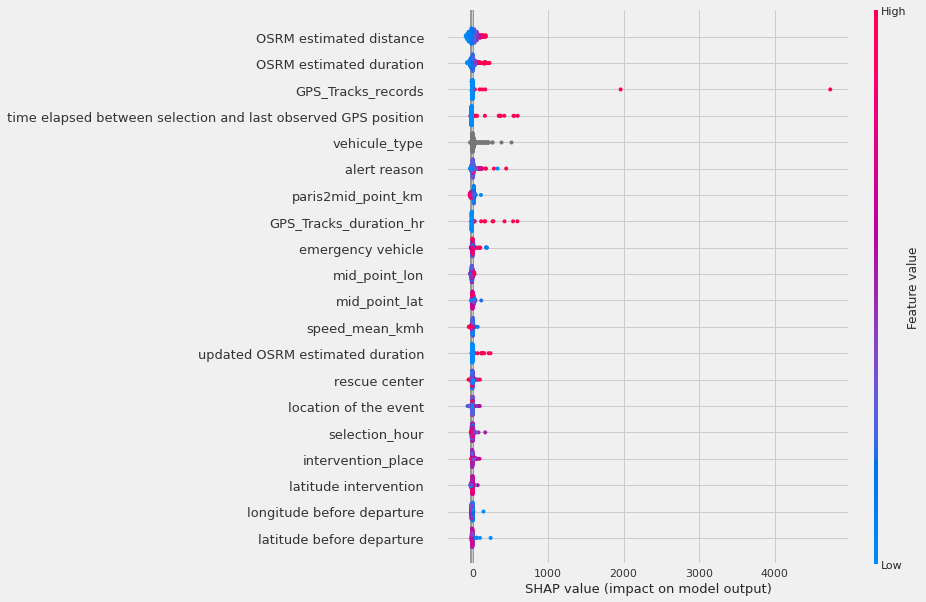

In [164]:
#@title summary plot - worse prediction
shap.initjs()
shap.summary_plot(res_shapvals_worse.iloc[:,:-1].values, res_df.iloc[:300, 6:])
# the worse predictions can be recognized as
#   strong effects (> 500) from GPS_tracking features.
# even though those features do also contribute in good prediction but with a less strength. 

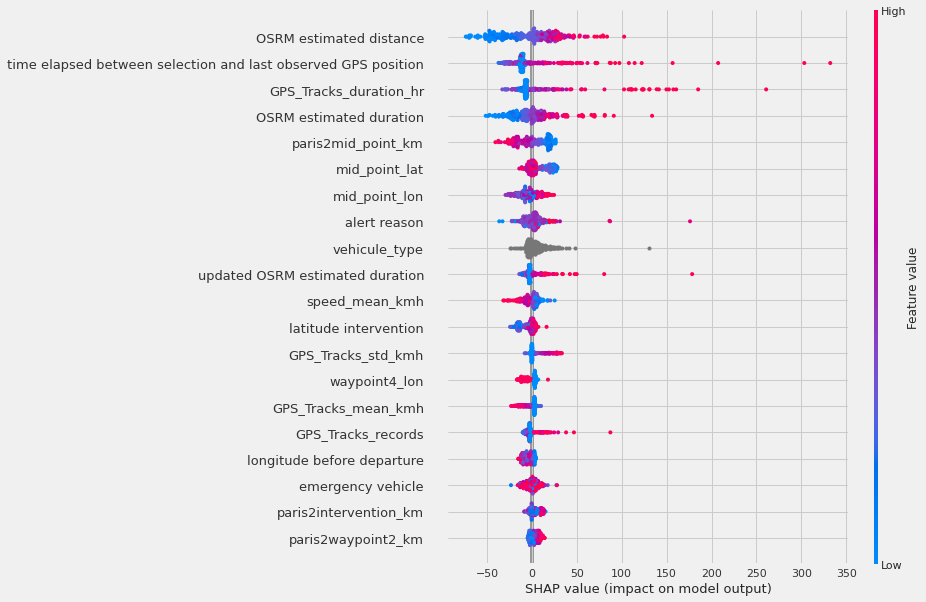

In [165]:
#@title summary plot - best prediction
shap.initjs()
shap.summary_plot(res_shapvals_best.iloc[:,:-1].values, res_df.iloc[-300:, 6:])

In [166]:
res_shapvals_worse.abs().describe().T.sort_values('std', ascending=False).head(10)

count   mean     std   min    25%    50%    75%      max
GPS_Tracks_records                                 300.000 26.133 295.569 0.125  1.651  2.264  2.689 4735.127
time elapsed between selection and last observe... 300.000 23.137  72.442 0.173  9.589 10.991 12.205  599.397
GPS_Tracks_duration_hr                             300.000 15.156  57.404 0.481  6.031  6.990  7.644  595.129
vehicule_type                                      300.000 22.676  55.726 0.007  2.937  5.508 11.170  515.524
alert reason                                       300.000 19.287  42.169 0.105  4.577  8.770 16.498  446.657
OSRM estimated duration                            300.000 30.347  40.798 0.224  7.266 16.151 33.459  225.989
OSRM estimated distance                            300.000 42.635  33.893 0.742 19.513 35.354 55.426  176.785
updated OSRM estimated duration                    300.000  7.277  25.004 0.112  2.043  2.654  3.573  239.547
emergency vehicle                                  300.000  9.552  21.366 0.038  2.109  4.616  9.339  192.191
latitude before departure                          300.000  5.907  15.826 0.008  1.986  3.565  6.166  241.008

In [176]:
res_shapvals_best.abs().describe().T.sort_values('std', ascending=False).head(10)

count   mean    std   min    25%    50%    75%     max
GPS_Tracks_duration_hr                             300.000 19.432 34.746 0.258  6.325  7.706 13.951 260.800
time elapsed between selection and last observe... 300.000 21.983 33.090 0.138 10.261 12.298 24.430 332.165
OSRM estimated distance                            300.000 26.090 18.822 0.111 11.857 23.325 36.451 102.660
OSRM estimated duration                            300.000 16.878 17.072 0.064  5.802 12.140 22.156 133.780
alert reason                                       300.000  8.151 13.165 0.016  2.936  5.561  9.003 176.019
updated OSRM estimated duration                    300.000  6.668 12.721 0.021  2.338  3.369  7.966 178.395
vehicule_type                                      300.000  7.899 10.389 0.034  2.548  5.122  9.432 130.301
GPS_Tracks_std_kmh                                 300.000  6.050  9.728 0.003  0.216  0.690  6.781  33.347
mid_point_lat                                      300.000  9.129  9.135 0.025  2.049  4.253 18.308  28.440
paris2mid_point_km                                 300.000 14.068  8.215 0.063  6.255 16.213 20.134  40.668

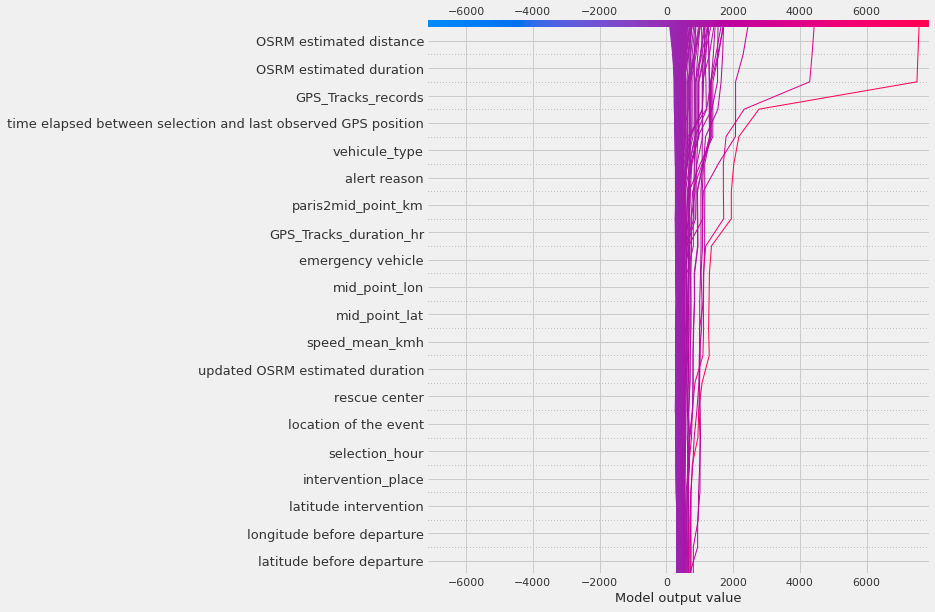

In [196]:
# Worse prediction
explainer = shap.TreeExplainer(mY1)
shap_values = explainer.shap_values(res_pool.slice(list(range(300))))
shap.decision_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=res_df.iloc[300:, 6:])

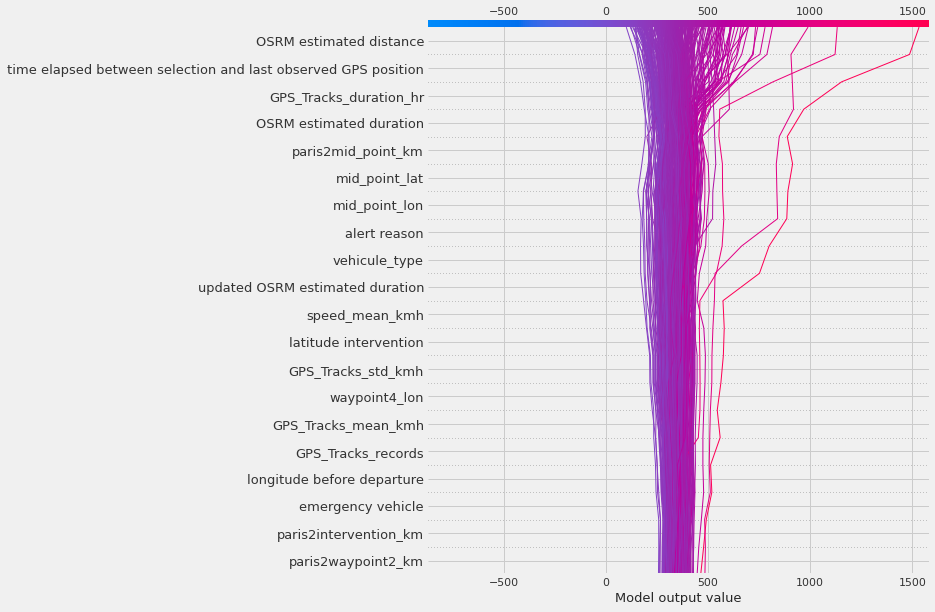

In [197]:
# Best prediction
explainer = shap.TreeExplainer(mY1)
n = res_df.shape[0]
shap_values = explainer.shap_values(res_pool.slice(list(range(n-300,n))))
shap.decision_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=res_df.iloc[-300:, 6:])

# Can we correct the under-estimation of Y1 model ?
Can the model learn P(under-estimation | X, y_pred) ?

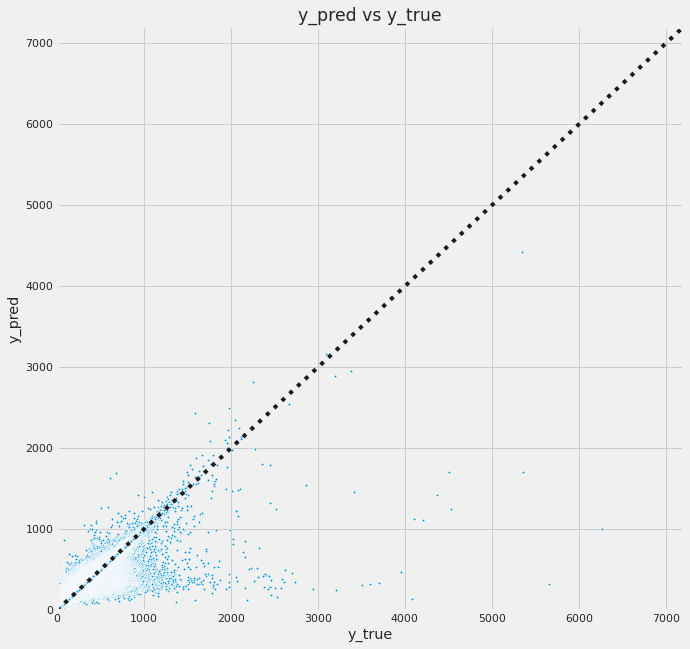

In [170]:
#@title Y1 - y_true vs y_pred (train dataset)
import helpers.analyze_model
train_res_df = res_df
helpers.analyze_model.display_true_vs_pred(train_res_df, y_lim=60*120)
# Starting from 250s, the model under-estimates the duration

Text(0.5, 1.0, 'Number of over/underestimations per segment of actual value')

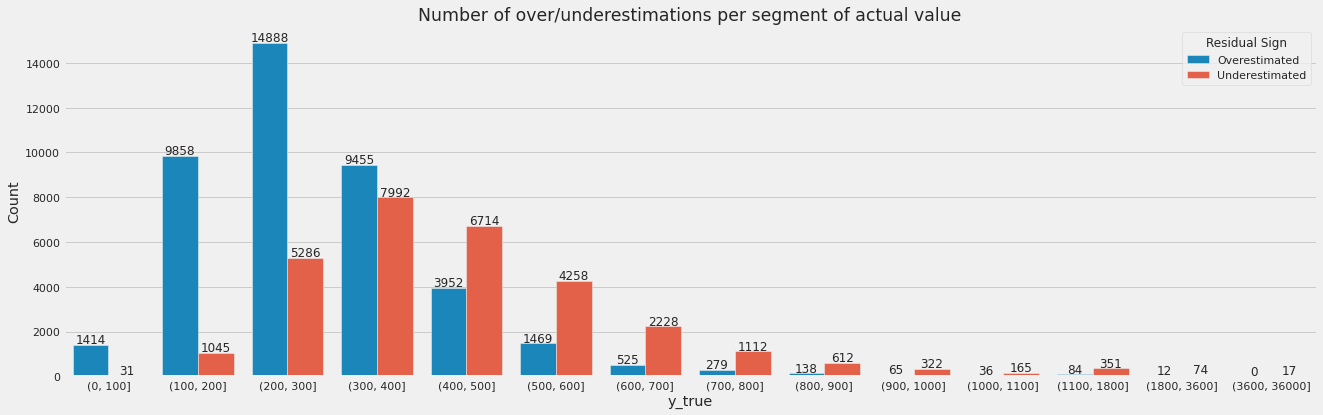

In [175]:
#@title Number of underestimated/overestimated wrt y_true
plt.figure(figsize=(20, 6))
bins = list(range(0, 1200, 100)) + [1800, 3600, 10*3600]
g = train_res_df.groupby(
    [train_res_df.resid < 0,
     pd.cut(train_res_df.y_true, bins)])
g = g.size().reset_index()
g.rename({0: 'Count'}, axis=1, inplace=True)
g['Residual Sign'] = g.apply(lambda x: 'Underestimated' if x['resid'] else 'Overestimated', axis=1)

barplt = sns.barplot(x='y_true', y='Count', data=g, hue='Residual Sign')

for i, p in enumerate(barplt.patches):
  pos = (p.get_x() + p.get_width() / 2.0, p.get_height() )
  barplt.annotate(f'{p.get_height():.0f}', 
                  pos, 
                  ha = 'center', 
                  va = 'center', 
                  xytext = (0, 5),
                  textcoords = 'offset points',
                  )
plt.title('Number of over/underestimations per segment of actual value')
# barplt.set_yscale("log")

# After y_true=400s, model starts underestimate Y1
# Underestimation proportion is getting worse as Y goes higher.
# after 1800s, quasi total of predictions are underestimated.

Text(0.5, 1.0, 'Number of over/underestimations per segment of predicted value')

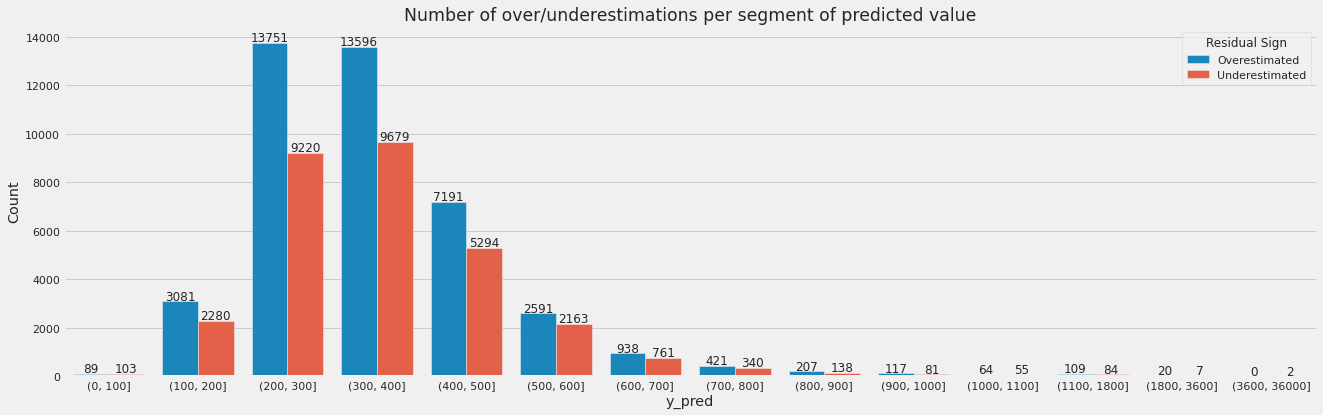

In [174]:
#@title Number of underestimated/overestimated wrt y_pred
plt.figure(figsize=(20, 6))
# bins = list(range(0, 1200, 100)) + [1800, 3600, 10*3600]
g = train_res_df.groupby(
    [train_res_df.resid < 0,
     pd.cut(train_res_df.y_pred, bins)])
g = g.size().reset_index()
g.rename({0: 'Count'}, axis=1, inplace=True)
g['Residual Sign'] = g.apply(lambda x: 'Underestimated' if x['resid'] else 'Overestimated', axis=1)

barplt = sns.barplot(x='y_pred', y='Count', data=g, hue='Residual Sign')

for i, p in enumerate(barplt.patches):
  pos = (p.get_x() + p.get_width() / 2.0, p.get_height() )
  barplt.annotate(f'{p.get_height():.0f}', 
                  pos, 
                  ha = 'center', 
                  va = 'center', 
                  xytext = (0, 5),
                  textcoords = 'offset points',
                  )
plt.title('Number of over/underestimations per segment of predicted value')

By projection the numbers of under/over-estimations on y_pred,  we can notice that the The model tries to compensate the underestimation by overestimating for a large range of y_pred [0, 1100]. There is only a tiny part (1800, +] where underestimation has occurred.